In [1]:
import numpy as np
def generate_weighted_watts_strogatz_numpy(num_nodes, k_neighbors, p_rewire, seed=None):
    """
    Generates the weighted adjacency matrix for a Watts-Strogatz (Small-World) graph 
    where edge weights are uniformly distributed between 0 and 1.

    Args:
        num_nodes (int): The total number of nodes (N).
        k_neighbors (int): The number of neighbors each node connects to in the 
                           initial ring lattice (k, must be even).
        p_rewire (float): The probability of rewiring an edge (p), between 0 and 1.
        seed (int, optional): Seed for reproducibility.

    Returns:
        np.ndarray: The symmetric weighted adjacency matrix (float dtype).
    """
    if seed is not None:
        np.random.seed(seed)
    
    if k_neighbors % 2 != 0:
        raise ValueError("k_neighbors must be an even integer.")
        
    # Use float for weights
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=float)
    half_k = k_neighbors // 2
    
    # 1. Create the initial Weighted Ring Lattice
    for i in range(num_nodes):
        for j in range(1, half_k + 1):
            
            neighbor_right = (i + j) % num_nodes
            neighbor_left = (i - j) % num_nodes
            
            # Generate a random weight for the new edge (between 0 and 1)
            new_weight = np.random.uniform(0.1, 1.0) # Start weights slightly above 0 to differentiate from non-edges
            
            # Connect to the right neighbor
            if i != neighbor_right and adj_matrix[i, neighbor_right] == 0:
                adj_matrix[i, neighbor_right] = new_weight
                adj_matrix[neighbor_right, i] = new_weight # Symmetric
            
            # Connect to the left neighbor
            if i != neighbor_left and adj_matrix[i, neighbor_left] == 0:
                adj_matrix[i, neighbor_left] = new_weight
                adj_matrix[neighbor_left, i] = new_weight # Symmetric

    # 2. Randomly Rewire Edges
    
    # Iterate over upper triangular unique edges
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            # Check if an edge exists (weight > 0)
            if adj_matrix[i, j] > 0:
                
                if np.random.rand() < p_rewire:
                    
                    # a. Remove the existing edge (set weight to 0)
                    adj_matrix[i, j] = 0.0
                    adj_matrix[j, i] = 0.0
                    
                    # b. Find a new node 'w' to connect to
                    new_neighbor = i
                    # Keep trying until a new node is found that isn't i and isn't already connected
                    while new_neighbor == i or adj_matrix[i, new_neighbor] > 0:
                        new_neighbor = np.random.randint(0, num_nodes)
                        
                    # Generate a random weight for the new edge (between 0 and 1)
                    new_weight = np.random.uniform(0.1, 1.0)
                        
                    # c. Add the new edge (i, new_neighbor) with the new weight
                    adj_matrix[i, new_neighbor] = new_weight
                    adj_matrix[new_neighbor, i] = new_weight # Symmetric

    return adj_matrix

In [2]:
import numpy as np
import torch 
import networkx as nx

datasetPath = "data/France/transportsIDF/"

def read_matrix_from_csv_loadtxt(filepath, delimiter=',', dtype=float):
  """
  Reads a NumPy matrix from a CSV file using np.loadtxt().

  Args:
    filepath (str): The path to the CSV file.
    delimiter (str): The character separating values in the CSV file (default is comma).

  Returns:
    numpy.ndarray: The matrix read from the CSV file.
  """
  try:
    matrix = np.loadtxt(filepath, delimiter=delimiter, dtype=dtype)
    print(f"Successfully loaded matrix from {filepath} using np.loadtxt().")
    return matrix
  except FileNotFoundError:
    print(f"Error: The file '{filepath}' was not found.")
    return None
  except Exception as e:
    print(f"An error occurred while loading the file: {e}")
    return None

p_vectors_array = read_matrix_from_csv_loadtxt(datasetPath + "idf_attr_nnorm.csv")
adjacency_matrix = read_matrix_from_csv_loadtxt(datasetPath + "idf_adjacency_nnorm.csv")
names = read_matrix_from_csv_loadtxt(datasetPath + "idf_names_nnorm.csv", dtype=str)

# random_weights = np.random.normal(loc=0, scale=1, size=(50, 50))
# symmetric_matrix = random_weights + random_weights.T
# np.fill_diagonal(symmetric_matrix, 0)
# symmetric_matrix /= np.max(symmetric_matrix)
# symmetric_matrix = np.abs(symmetric_matrix)
# symmetric_matrix = np.where(symmetric_matrix < 0.15, 0.0, symmetric_matrix)
# adjacency_matrix = symmetric_matrix

adjacency_matrix= generate_weighted_watts_strogatz_numpy(num_nodes=50, 
                                                k_neighbors=4, 
                                                p_rewire=0.1, 
                                                seed=42)
p_vectors_array = p_vectors_array[0:50, :]
names = names[0:50]


num_nodes = adjacency_matrix.shape[0]
dimP = 20

G = nx.from_numpy_array(adjacency_matrix)
G.remove_edges_from(nx.selfloop_edges(G)) # Remove self-loops

Successfully loaded matrix from data/France/transportsIDF/idf_attr_nnorm.csv using np.loadtxt().
Successfully loaded matrix from data/France/transportsIDF/idf_adjacency_nnorm.csv using np.loadtxt().
Successfully loaded matrix from data/France/transportsIDF/idf_names_nnorm.csv using np.loadtxt().


In [3]:
from scipy.spatial.distance import cosine # For cosine similarity

def compute_node_feature_assortativity(G, node_features):
    """
    Computes a node-level assortativity-like score based on d-dimensional features.
    For each node, it calculates the average similarity to its neighbors
    and compares it to the average similarity to all other nodes.

    Args:
        adj_matrix (np.ndarray): The adjacency matrix of the graph (N x N).
        node_features (np.ndarray): A (N x D) array where N is the number of nodes
                                     and D is the dimensionality of features.

    Returns:
        dict: A dictionary where keys are node IDs (integers) and values are
              their respective node-level assortativity scores.
              A higher positive score indicates more assortative mixing for that node.
              A negative score indicates disassortative mixing for that node.
    """
    num_nodes = G.number_of_nodes()
    if node_features.shape[0] != num_nodes:
        raise ValueError("Number of nodes in adjacency matrix and features must match.")

    # 1. Create a NetworkX graph from the adjacency matrix

    # Add features to nodes
    for i in range(num_nodes):
        G.nodes[i]['features'] = node_features[i]

    def vector_similarity(vec1, vec2):
        # Handle cases where vectors might be identical to avoid cosine(0,0) issues
        if np.array_equal(vec1, vec2):
            return 1.0
        return 1 - cosine(vec1, vec2)

    node_assortativity_scores = {}

    for node_id in G.nodes():
        node_feat = G.nodes[node_id]['features']
        neighbors = list(G.neighbors(node_id))

        if not neighbors:
            # A node with no neighbors can't have neighbor similarity
            node_assortativity_scores[node_id] = 0.0 # Or np.nan, depending on desired behavior
            continue

        # Calculate average similarity to neighbors
        neighbor_similarities = []
        for neighbor_id in neighbors:
            neighbor_feat = G.nodes[neighbor_id]['features']
            neighbor_similarities.append(vector_similarity(node_feat, neighbor_feat))
        avg_neighbor_similarity = np.mean(neighbor_similarities)

        # Calculate average similarity to all other nodes (baseline)
        all_other_node_similarities = []
        for other_node_id in G.nodes():
            if other_node_id != node_id: # Don't compare a node to itself
                other_node_feat = G.nodes[other_node_id]['features']
                all_other_node_similarities.append(vector_similarity(node_feat, other_node_feat))

        if not all_other_node_similarities: # Should only happen with single node graphs
            baseline_avg_similarity = avg_neighbor_similarity # Fallback if no other nodes
        else:
            baseline_avg_similarity = np.mean(all_other_node_similarities)

        # Compute the node's assortativity score
        score = avg_neighbor_similarity - baseline_avg_similarity
        node_assortativity_scores[node_id] = score

    return node_assortativity_scores

print("--- Assortativity by node ---")
node_scores_1 = compute_node_feature_assortativity(G, p_vectors_array)
# for node, score in node_scores_1.items():
#     print(f"Node {node}: {score:.3f}")
# Expected: Nodes within clusters (0,1,2 and 3,4,5) should have positive scores.

print("\n" + "="*40 + "\n")

--- Assortativity by node ---




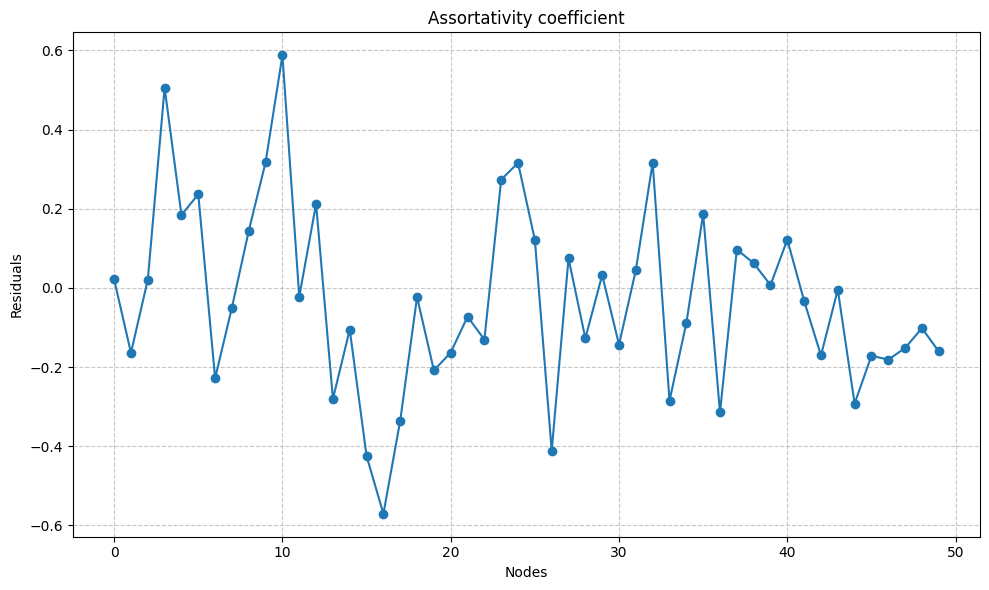

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) # Set the size of the plot for better readability

plt.plot(node_scores_1.values(), marker='o', linestyle='-')

# Add a horizontal line at y=0

# --- Customize the Plot ---
plt.xlabel('Nodes') # Label for the x-axis
plt.ylabel('Residuals') # Label for the y-axis, updated to reflect the ratio
plt.title('Assortativity coefficient') # Title of the plot, updated
plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for easier reading
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping
plt.show()

In [5]:
from framework.trainFct import *
from torch_geometric.data import Data
from framework.visuals import *

latent_dim = 2
input_dim = dimP
batch_size = 256


dataset = []
data = Data(x=torch.tensor(p_vectors_array, dtype=torch.float), 
            edge_index=adj_matrix_to_edge_index(adjacency_matrix)[0], 
            edge_labels=adj_matrix_to_edge_index(adjacency_matrix)[1],
            adjacency_matrix=torch.tensor(adjacency_matrix))
dataset.append(data)

# Select a single graph to train on
single_graph = dataset[0]

# Wrap in list for compatibility with DataLoader-like expectations
single_graph_list = [single_graph]


/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:128: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalINS6_17basic_string_viewIcNS6_11char_traitsIcEEEEEE
  Referenced from: <2BF76774-0954-3F15-B7FE-8A5E5111D7DF> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:166: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/

In [6]:
dropout = 0
phase1_epochs = 1200
#phase1_epochs = 300
phase2_epochs = 200
#phase2_epochs = 100
lr_phase1 = 0.005
latent_dim = 2
device = "cuda" if torch.cuda.is_available() else "cpu"


encoder = MLPEncoder(
    input_dim=input_dim,
    hidden_dims=[96, 64],
    latent_dim=latent_dim,
    mlp_layers=2,
    dropout=0.2,
    activation=nn.ReLU()
)

node_decoder = NodeAttributeVariationalDecoder(
    latent_dim=latent_dim,
    output_dim=input_dim,
    #hidden_dims=[5000, 128],
    #hidden_dims=[2000, 128],
    hidden_dims=[128],
    dropout=dropout,
    activation=nn.ReLU(),
    loss_options= {
        "lambda_comp_variance": 100,
        "lambda_decoder_variance":20,
        "debug": False},
    clip_var = 30,
)

# Create KL annealing scheduler
kl_scheduler = KLAnnealingScheduler(
    anneal_start=0.0,
    #anneal_end=0.001,
    #anneal_end=0.8,
    anneal_end=1,
    anneal_steps=phase1_epochs * len(single_graph_list),
    anneal_type='sigmoid',
)

# Create initial model with only node decoder
model_phase1 = GraphVAE(
    encoder=encoder,
    decoders=[node_decoder],
    kl_scheduler=kl_scheduler,
    compute_latent_manifold=False,
)


In [7]:
import os

if os.path.exists("model_phase1_reducedIDF.pth"):
    print("Loading pretrained model")
    model_phase1.load_state_dict(torch.load('model_phase1_reducedIDF.pth'))
else:
    print("=== Starting Phase 1: Training encoder with node feature reconstruction ===")

    # Phase 1 training
    history_phase1 = train_phase1(
        model=model_phase1,
        data_loader=single_graph_list,
        num_epochs=phase1_epochs,
        lr=lr_phase1,
        weight_decay=1e-5,
        verbose=True,
        device=device,
        loss_coefficient=1
    )

    print("\n=== Phase 1 Complete ===")

    torch.save(model_phase1.state_dict(), 'model_phase1_reducedIDF.pth')
    print("\n=== Phase 1 Saved ===")

    visualize_training(history_phase1)
    visualize_node_features_reconstruction(model_phase1, single_graph, sample_features=dimP)
    visualize_latent_space(model_phase1, [single_graph])


Loading pretrained model


/var/folders/qc/fbm2wz190nqd87d2mq7l90_80000gn/T/ipykernel_17939/1371347935.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_phase1.load_state_dict(torch.load('mode

In [8]:
# model_phase1.eval()

# with torch.no_grad():
#     x = single_graph.x.to(device)
#     edge_index = single_graph.edge_index.to(device)
#     latent_mu = model_phase1.encode(x, edge_index=edge_index)

# latent_points = latent_mu[0]

In [9]:
# model_phase1.train_rbf_layer(
#     decoder_name="node_attr_decoder",
#     decoder_variance_target_name="node_features_logvar",
#     latent_samples=latent_points,
#     n_centers=24,  
#     a=2,
#     n_epochs= 20000,
#     lr=0.05,
#     force=True)

Computing metric tensors for 10201 grid points...


Grid compute: 100%|██████████| 10201/10201 [00:01<00:00, 7154.55it/s]


Completed. Cached 10201 / 10201 points.


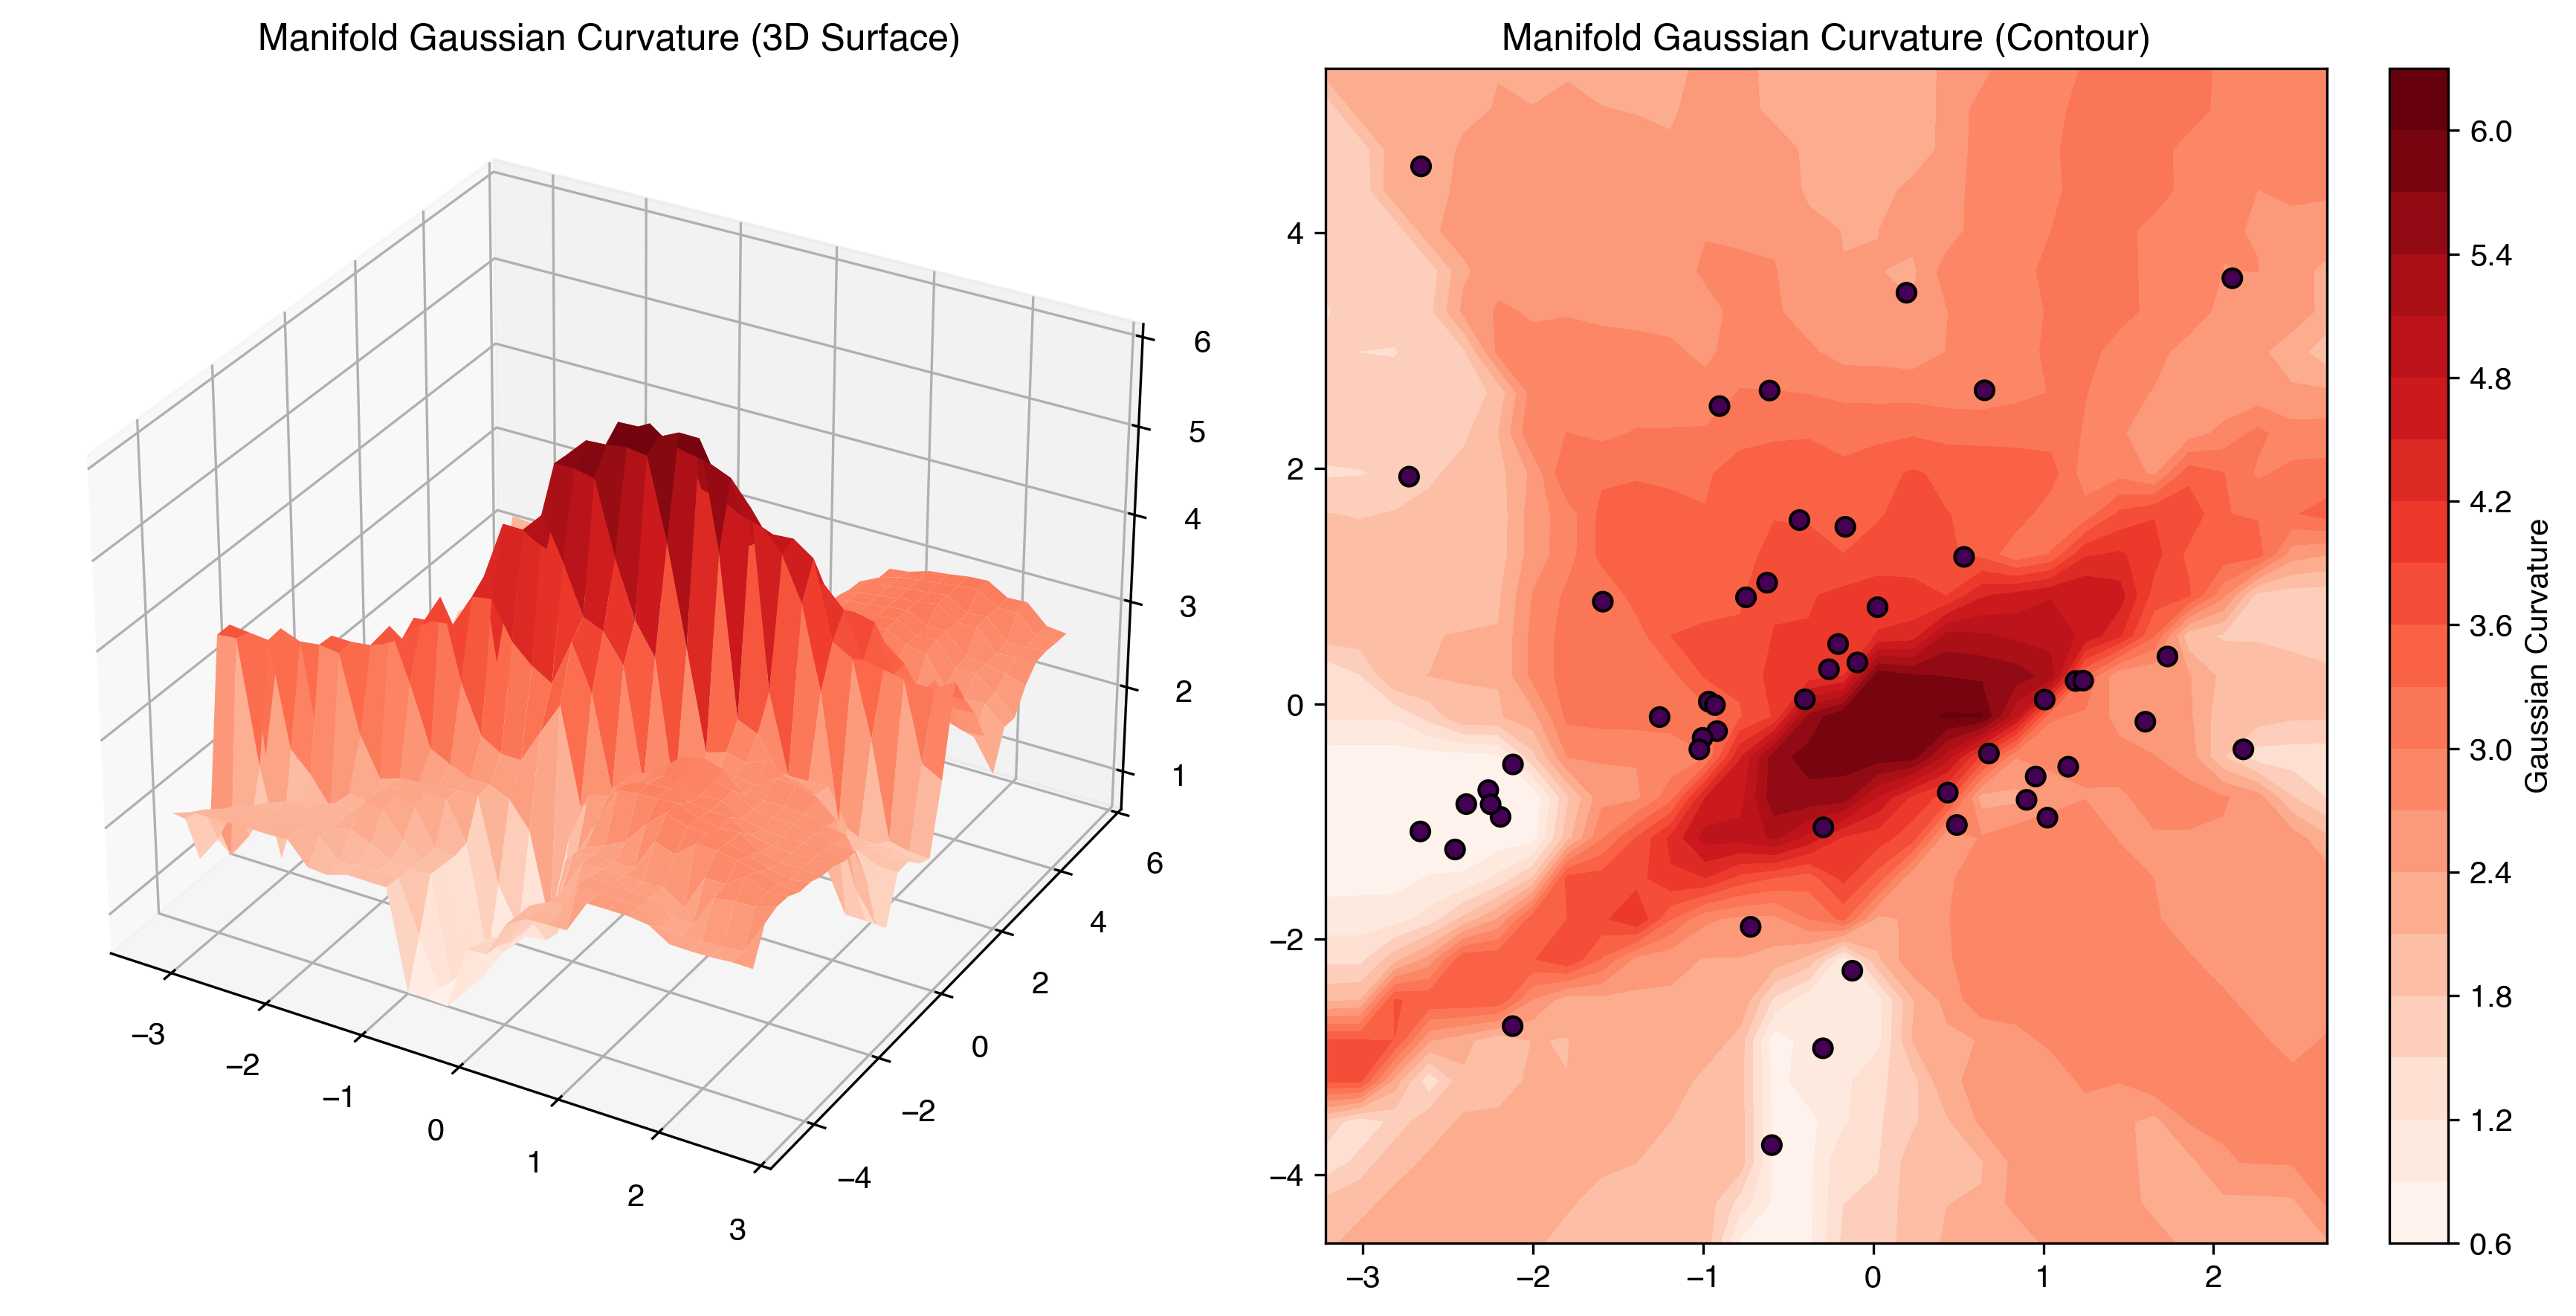

Calculating 1225 pairwise Riemannian distances using linear_interpolation_distance (batch mode)...


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 1241.79it/s]

Distance matrix calculation complete.


In [10]:
import copy
from framework.boundedManifold import BoundedManifold
from framework.torchVersions.distanceApproximations import DistanceApproximations
model_phase1 = model_phase1.to('cpu')
model_phase2 = copy.deepcopy(model_phase1)

model_phase1.eval()

with torch.no_grad():
    x = single_graph.x.to(device)
    edge_index = single_graph.edge_index.to(device)
    latent_mu = model_phase1.encode(x, edge_index=edge_index)

latent_points = latent_mu[0]

model_phase1.set_compute_latent_manifold(True)
model_phase1.construct_latent_manifold(bounds=BoundedManifold.hypercube_bounds(latent_points, margin=0.1, relative=True), force=True)
model_phase1.get_latent_manifold().compute_full_grid_metric_tensor()
model_phase1.get_latent_manifold().visualize_manifold_curvature(data_points=latent_points)

with torch.no_grad():
    dists_phase1 = model_phase1.get_latent_manifold().create_riemannian_distance_matrix(latent_points, 
                                                                                        DistanceApproximations.linear_interpolation_distance, 
                                                                                        batch_size=8, num_points=20)


In [11]:
# def pointwise_RBF_variance(z: torch.Tensor) -> float:
#     return model_phase1.get_rbf_estimate(z.float()).sum()

# def pointwise_RBF_entropy(z: torch.Tensor) -> float:
#     logvar = -0.5 * torch.log(model_phase1.get_rbf_estimate(z.float()).sum())
#     return  0.5 * ((1 + np.log(2 * np.pi)) + logvar.sum())

# model_phase1.get_latent_manifold().plot_on_manifold_grid(pointwise_RBF_variance, "Precision",
#                                                          data_points=latent_points, resolution=60)

# model_phase1.get_latent_manifold().plot_on_manifold_grid(pointwise_RBF_entropy, "RBF Entropy",
#                                                          data_points=latent_points, resolution=60)

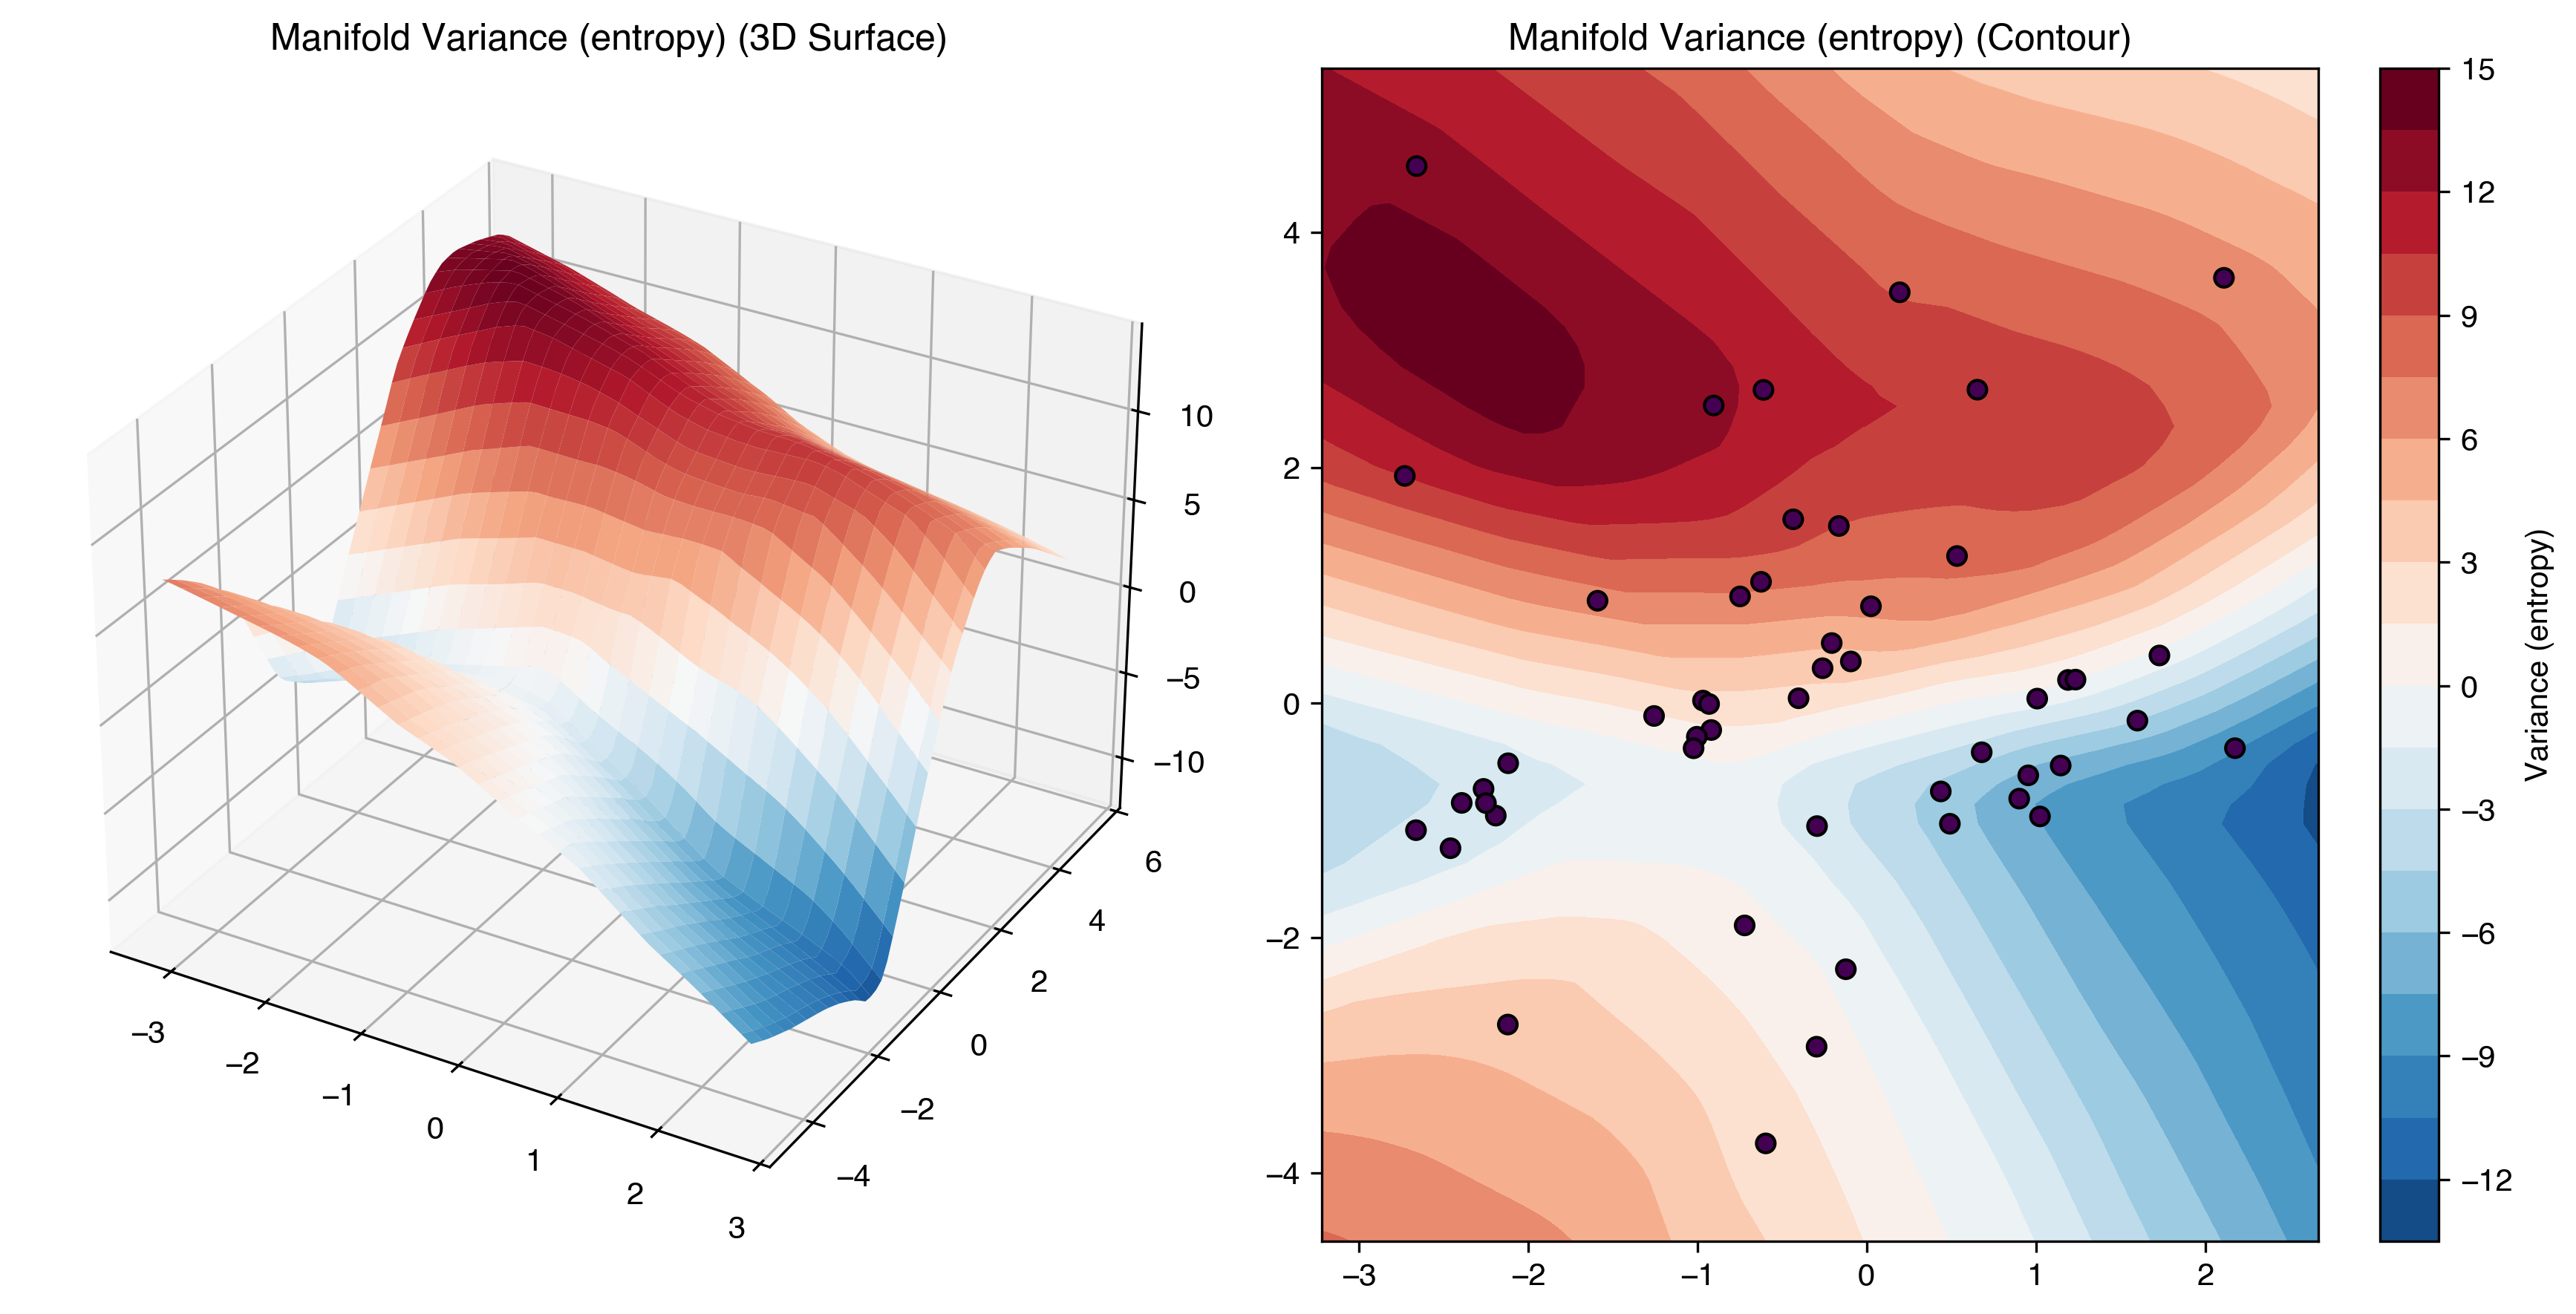

In [12]:
def pointwise_entropy(z: torch.Tensor) -> float:
    logvar = model_phase1.decode(z.float())["node_attr_decoder"]["node_features_logvar"]
    return  0.5 * (len(logvar) * (1 + np.log(2 * np.pi)) + logvar.sum())

# def pointwise_variance(z: torch.Tensor) -> float:
#     logvar = model_phase1.decode(z.float())["node_attr_decoder"]["node_features_logvar"]
#     return logvar.sum()

# model_phase1.get_latent_manifold().plot_on_manifold_grid(pointwise_variance, "Variance (entropy)",
#                                                          data_points=latent_points, resolution=60)

model_phase1.get_latent_manifold().plot_on_manifold_grid(pointwise_entropy, "Variance (entropy)",
                                                         data_points=latent_points, resolution=60)

In [13]:
# mse = torch.zeros(num_nodes)
# entropies = torch.zeros(num_nodes)

# for i in range(num_nodes):
#     mse[i] = ((recon[i]-single_graph.x[i])**2).sum()
#     entropies[i] = pointwise_entropy(latent_points[i])
# model_phase1.get_latent_manifold().visualize_manifold_curvature(data_points=latent_points, labels=mse)

In [14]:
# k = 50
# topk_values, topk_indices = torch.topk(mse, k)
# names[topk_indices]

In [15]:
# import statsmodels.api as sm
# x1 = single_graph.x[:, 10].flatten().numpy().reshape(-1, 1)
# x2 = entropies.detach().flatten().numpy().reshape(-1, 1)

# y = mse.flatten().detach().numpy()

# model = sm.OLS(x1,y)
# results = model.fit()
# print(results.summary())
# model = sm.OLS(x2,y)
# results = model.fit()
# print(results.summary())

In [16]:
# i = int(np.random.random() * num_nodes)
# a = single_graph.x[i]
# a_r = model_phase1(single_graph.x[i].unsqueeze(0))


# colors = ['lightgray', 'red']
# from matplotlib.colors import ListedColormap
# cmap = ListedColormap(colors)

# fig = plt.figure(figsize=(18, 6))
# ax1 = fig.add_subplot(121)
# ax1.set_title(f'Recon test ({i} - {names[i]})')
# ax1.plot(a, marker='o', linestyle='-')
# ax1.plot(a_r["outputs"]["node_attr_decoder"]["node_features"].detach().squeeze(), marker='o', linestyle='-')
# ax1.grid(True, linestyle='--', alpha=0.7) # Add a grid for easier reading
# ax2 = fig.add_subplot(122)
# ax2.set_title(f'Points on Manifold')
# points_np = latent_points.detach().cpu().numpy()                
# labels_np = np.zeros(num_nodes)
# labels_np[i] = 1
# ax2.scatter(points_np[:, 0], points_np[:, 1], c=labels_np, cmap=cmap, edgecolors='k')
# plt.tight_layout()
# plt.show()

In [17]:
# for j in range(20):
#     weights = [p_vectors_array[i, j] for i in range(num_nodes)]

#     # 4. Plot the distribution of the weights (Histogram)
#     plt.figure(figsize=(10, 6))

#     # Plot a histogram of the weights
#     # Use 'density=True' to show probability density instead of count
#     plt.hist(weights, bins=20, edgecolor='black', alpha=0.7, density=True)


#     # Add labels and title
#     plt.title(f'Distribution of Edge Weights - i={j}')
#     plt.xlabel('Weight Value')
#     plt.ylabel('Density')
#     plt.grid(axis='y', alpha=0.5)
#     plt.show()


In [18]:
from framework.KLAnnealingScheduler import NoKLScheduler

lr_phase2 = 0.001
distance_mode = "linear_interpolation" # "linear_interpolation"

print("=== Starting Phase 2: Freezing encoder and adding adjacency decoder ===")

model_phase2.set_compute_latent_manifold(True)
model_phase2.construct_latent_manifold(bounds=BoundedManifold.hypercube_bounds(latent_points, margin=0.1, relative=True), force=True)
model_phase2.set_encoder_freeze(True)

#torch.autograd.set_detect_anomaly(True)

distance_decoder = ManifoldHeatKernelDecoder(
    distance_mode=distance_mode,
    latent_dim=latent_dim,
    #heat_time=torch.logspace(start=-1, end=2, steps=10).tolist(),  # Adjust for local vs global structure
    num_eigenvalues=500,
    num_integration_points=20,
    name="adj_decoder",
    max_ema_epochs=phase2_epochs,
    #ema_lag_factor=0.1
)

# Add to your GraphVAE model
model_phase2.add_decoder(distance_decoder)

# Set reference decoder (the node attribute decoder)
#model_phase2.get_decoder("adj_decoder").giveManifoldInstance(model_phase2.get_latent_manifold())
model_phase2.get_decoder("adj_decoder").giveVAEInstance(model_phase2)

# Reset KL scheduler for phase 2
model_phase2.kl_scheduler = NoKLScheduler()

torch.nn.utils.clip_grad_norm_(model_phase2.parameters(), 1)
#torch.autograd.set_detect_anomaly(True)

# Phase 2 training
history_phase2 = train_phase2(
    model=model_phase2,
    data_loader=single_graph_list,
    latent_points=latent_points,
    num_epochs=phase2_epochs,
    lr=lr_phase2,
    weight_decay=1e-5,
#    decoder_weights={"adj_decoder": -1, "node_attr_decoder":-1 },
    decoder_weights={"adj_decoder": 1, "node_attr_decoder":0.0 },
    verbose=True,
    device=device,
)

print("\n=== Phase 2 Complete ===")



=== Starting Phase 2: Freezing encoder and adding adjacency decoder ===


Computing distances in batches:   0%|          | 0/154 [00:00<?, ?it/s]

Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 1495.15it/s]

Current sigma:  7.040327548980713 Selected sigma:  7.040327548980713
Selected heat times: tensor([ 0.0485,  0.0643,  0.0851,  0.1127,  0.1492,  0.1975,  0.2615,  0.3463,
         0.4585,  0.6070,  0.8037,  1.0641,  1.4090,  1.8655,  2.4700,  3.2703,
         4.3299,  5.7329,  7.5905, 10.0500])
Total Laplacian loss: 68.876160 - With referent sigma: 68.876160



/Users/aldric-l/Library/CloudStorage/OneDrive-Personnel/Documents/Scolarité - Aldric/Supérieur/ENS/M2 MVA/S3 Stage/Topological-GVAE/framework/geometry.py:441: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  min_log = float(torch.log10(torch.tensor(t_min)).item()) if t_min > 0.0 else clamp_min_log
/Users/aldric-l/Library/CloudStorage/OneDrive-Personnel/Documents/Scolarité - Aldric/Supérieur/ENS/M2 MVA/S3 Stage/Topological-GVAE/framework/geometry.py:442: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_log = float(torch.log10(torch.tensor(t_max)).item()) if t_max > 0.0 else clamp_max_log
Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 1877.59it/s]


Current sigma:  7.006413459777832 Selected sigma:  7.037614345550537
Total Laplacian loss: 68.920288 - With referent sigma: 68.920876


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2044.50it/s]


Current sigma:  7.225722312927246 Selected sigma:  7.0526628494262695
Total Laplacian loss: 68.956978 - With referent sigma: 68.954338


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 1854.79it/s]


Current sigma:  7.250955581665039 Selected sigma:  7.068526268005371
Total Laplacian loss: 68.951279 - With referent sigma: 68.944473


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2091.22it/s]


Current sigma:  7.398188591003418 Selected sigma:  7.0948991775512695
Total Laplacian loss: 68.776054 - With referent sigma: 68.758217


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2124.08it/s]


Current sigma:  7.3933610916137695 Selected sigma:  7.118776321411133
Total Laplacian loss: 68.817429 - With referent sigma: 68.791710


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2100.15it/s]


Current sigma:  7.711456775665283 Selected sigma:  7.166191101074219
Total Laplacian loss: 68.637810 - With referent sigma: 68.587959


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2118.33it/s]


Current sigma:  7.511697292327881 Selected sigma:  7.193831920623779
Total Laplacian loss: 68.806473 - With referent sigma: 68.755814


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2114.05it/s]


Current sigma:  7.689345836639404 Selected sigma:  7.233473300933838
Total Laplacian loss: 68.744514 - With referent sigma: 68.674759


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2049.64it/s]


Current sigma:  8.105871200561523 Selected sigma:  7.303265571594238
Total Laplacian loss: 68.526833 - With referent sigma: 68.396439
Phase 2 - Epoch 10/200 - Loss: 68.5268, KL: 0.0000 (weight: 0.0000), Adj: 68.5268, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2102.67it/s]


Current sigma:  7.961186408996582 Selected sigma:  7.355899333953857
Total Laplacian loss: 68.735664 - With referent sigma: 68.604912


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2104.60it/s]


Current sigma:  8.21359634399414 Selected sigma:  7.424515247344971
Total Laplacian loss: 68.783409 - With referent sigma: 68.627754


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 515.30it/s]


Current sigma:  7.941514015197754 Selected sigma:  7.465875148773193
Total Laplacian loss: 68.712700 - With referent sigma: 68.539818


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 1403.27it/s]


Current sigma:  8.117822647094727 Selected sigma:  7.518031120300293
Total Laplacian loss: 68.556053 - With referent sigma: 68.300735


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2079.12it/s]


Current sigma:  8.119050025939941 Selected sigma:  7.566112518310547
Total Laplacian loss: 68.789299 - With referent sigma: 68.569031


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2080.16it/s]


Current sigma:  8.350703239440918 Selected sigma:  7.628879547119141
Total Laplacian loss: 68.627464 - With referent sigma: 68.331337


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2063.02it/s]


Current sigma:  8.784306526184082 Selected sigma:  7.721313953399658
Total Laplacian loss: 68.327873 - With referent sigma: 67.827423


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2073.26it/s]


Current sigma:  8.748096466064453 Selected sigma:  7.803456783294678
Total Laplacian loss: 68.652275 - With referent sigma: 68.243645


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2108.87it/s]


Current sigma:  8.735675811767578 Selected sigma:  7.8780341148376465
Total Laplacian loss: 68.433746 - With referent sigma: 67.877274


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2050.93it/s]


Current sigma:  9.019545555114746 Selected sigma:  7.96935510635376
Total Laplacian loss: 68.483681 - With referent sigma: 67.823982
Phase 2 - Epoch 20/200 - Loss: 68.4837, KL: 0.0000 (weight: 0.0000), Adj: 68.4837, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2110.84it/s]


Current sigma:  9.098867416381836 Selected sigma:  8.05971622467041
Total Laplacian loss: 68.485931 - With referent sigma: 67.800476


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2015.31it/s]


Current sigma:  9.382969856262207 Selected sigma:  8.165576934814453
Total Laplacian loss: 68.402939 - With referent sigma: 67.549545


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2125.70it/s]


Current sigma:  9.346638679504395 Selected sigma:  8.260062217712402
Total Laplacian loss: 68.534973 - With referent sigma: 67.665573


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2109.87it/s]


Current sigma:  9.3887357711792 Selected sigma:  8.350356101989746
Total Laplacian loss: 68.451866 - With referent sigma: 67.436905


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2112.72it/s]


Current sigma:  9.54638671875 Selected sigma:  8.446038246154785
Total Laplacian loss: 68.580803 - With referent sigma: 67.479767


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 1797.31it/s]


Current sigma:  9.92300033569336 Selected sigma:  8.56419563293457
Total Laplacian loss: 68.301933 - With referent sigma: 66.952827


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2132.81it/s]


Current sigma:  9.941811561584473 Selected sigma:  8.674405097961426
Total Laplacian loss: 68.459496 - With referent sigma: 67.148460


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2158.44it/s]


Current sigma:  9.917901992797852 Selected sigma:  8.773884773254395
Total Laplacian loss: 68.546623 - With referent sigma: 67.161819


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2036.50it/s]


Current sigma:  10.09146499633789 Selected sigma:  8.879290580749512
Total Laplacian loss: 68.561249 - With referent sigma: 67.096626


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2053.77it/s]


Current sigma:  10.595252990722656 Selected sigma:  9.01656723022461
Total Laplacian loss: 68.253677 - With referent sigma: 66.183311
Phase 2 - Epoch 30/200 - Loss: 68.2537, KL: 0.0000 (weight: 0.0000), Adj: 68.2537, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2109.82it/s]


Current sigma:  10.43571949005127 Selected sigma:  9.13010025024414
Total Laplacian loss: 68.343597 - With referent sigma: 66.430534


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2109.18it/s]


Current sigma:  10.702005386352539 Selected sigma:  9.255852699279785
Total Laplacian loss: 68.487564 - With referent sigma: 66.473358


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2143.59it/s]


Current sigma:  10.438764572143555 Selected sigma:  9.350485801696777
Total Laplacian loss: 68.518585 - With referent sigma: 66.396057


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2154.87it/s]


Current sigma:  10.750406265258789 Selected sigma:  9.462479591369629
Total Laplacian loss: 68.401794 - With referent sigma: 65.933044


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2078.47it/s]


Current sigma:  11.016843795776367 Selected sigma:  9.58682918548584
Total Laplacian loss: 68.416565 - With referent sigma: 65.895935


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2170.02it/s]


Current sigma:  10.979825973510742 Selected sigma:  9.698269844055176
Total Laplacian loss: 68.155670 - With referent sigma: 65.254639


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2087.37it/s]


Current sigma:  11.245869636535645 Selected sigma:  9.822077751159668
Total Laplacian loss: 68.111511 - With referent sigma: 64.793839


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2187.59it/s]


Current sigma:  11.474678039550781 Selected sigma:  9.954286575317383
Total Laplacian loss: 68.128227 - With referent sigma: 64.545059


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2063.07it/s]


Current sigma:  11.842966079711914 Selected sigma:  10.10538101196289
Total Laplacian loss: 68.105629 - With referent sigma: 64.251755


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2104.77it/s]


Current sigma:  11.850736618041992 Selected sigma:  10.245009422302246
Total Laplacian loss: 68.273857 - With referent sigma: 64.575424
Phase 2 - Epoch 40/200 - Loss: 68.2739, KL: 0.0000 (weight: 0.0000), Adj: 68.2739, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2148.32it/s]


Current sigma:  11.89579963684082 Selected sigma:  10.37707233428955
Total Laplacian loss: 68.327553 - With referent sigma: 64.564453


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2185.39it/s]


Current sigma:  12.018653869628906 Selected sigma:  10.50839900970459
Total Laplacian loss: 68.296288 - With referent sigma: 64.162117


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2108.01it/s]


Current sigma:  12.25781536102295 Selected sigma:  10.64835262298584
Total Laplacian loss: 68.235649 - With referent sigma: 63.570827


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2183.31it/s]


Current sigma:  12.22355842590332 Selected sigma:  10.774369239807129
Total Laplacian loss: 68.302704 - With referent sigma: 63.906994


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2119.23it/s]


Current sigma:  12.365813255310059 Selected sigma:  10.90168571472168
Total Laplacian loss: 68.028084 - With referent sigma: 62.685410


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2199.43it/s]


Current sigma:  12.75994873046875 Selected sigma:  11.050347328186035
Total Laplacian loss: 68.225250 - With referent sigma: 63.027691


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2067.87it/s]


Current sigma:  12.636173248291016 Selected sigma:  11.177213668823242
Total Laplacian loss: 68.277016 - With referent sigma: 62.982552


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2128.04it/s]


Current sigma:  13.190994262695312 Selected sigma:  11.338316917419434
Total Laplacian loss: 67.861313 - With referent sigma: 61.700691


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2188.18it/s]


Current sigma:  12.781301498413086 Selected sigma:  11.453755378723145
Total Laplacian loss: 68.143364 - With referent sigma: 62.274879


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2114.94it/s]


Current sigma:  13.287717819213867 Selected sigma:  11.600473403930664
Total Laplacian loss: 68.118996 - With referent sigma: 62.343426
Phase 2 - Epoch 50/200 - Loss: 68.1190, KL: 0.0000 (weight: 0.0000), Adj: 68.1190, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2130.92it/s]


Current sigma:  13.208598136901855 Selected sigma:  11.729124069213867
Total Laplacian loss: 68.261223 - With referent sigma: 62.061066


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2242.90it/s]


Current sigma:  13.200019836425781 Selected sigma:  11.846796035766602
Total Laplacian loss: 67.895782 - With referent sigma: 61.491699


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2114.34it/s]


Current sigma:  13.69503116607666 Selected sigma:  11.99465560913086
Total Laplacian loss: 68.397675 - With referent sigma: 62.216454


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2153.88it/s]


Current sigma:  13.668917655944824 Selected sigma:  12.128597259521484
Total Laplacian loss: 68.022934 - With referent sigma: 61.319115


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2057.01it/s]


Current sigma:  14.181400299072266 Selected sigma:  12.292821884155273
Total Laplacian loss: 67.939079 - With referent sigma: 60.982960


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2067.44it/s]


Current sigma:  14.482231140136719 Selected sigma:  12.467975616455078
Total Laplacian loss: 67.930267 - With referent sigma: 59.905773


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2112.63it/s]


Current sigma:  14.077326774597168 Selected sigma:  12.596724510192871
Total Laplacian loss: 67.993813 - With referent sigma: 61.069569


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2085.59it/s]


Current sigma:  14.607076644897461 Selected sigma:  12.757552146911621
Total Laplacian loss: 67.844536 - With referent sigma: 59.789852


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2173.18it/s]


Current sigma:  14.650259971618652 Selected sigma:  12.908968925476074
Total Laplacian loss: 67.831879 - With referent sigma: 59.878487


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2122.62it/s]


Current sigma:  15.647727966308594 Selected sigma:  13.128068923950195
Total Laplacian loss: 67.461929 - With referent sigma: 58.725529
Phase 2 - Epoch 60/200 - Loss: 67.4619, KL: 0.0000 (weight: 0.0000), Adj: 67.4619, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2091.56it/s]


Current sigma:  15.217229843139648 Selected sigma:  13.295202255249023
Total Laplacian loss: 68.010635 - With referent sigma: 59.963852


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2087.60it/s]


Current sigma:  15.165984153747559 Selected sigma:  13.444865226745605
Total Laplacian loss: 67.797523 - With referent sigma: 58.794605


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2163.99it/s]


Current sigma:  15.498574256896973 Selected sigma:  13.609162330627441
Total Laplacian loss: 67.981834 - With referent sigma: 59.018223


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2046.27it/s]


Current sigma:  15.546211242675781 Selected sigma:  13.764126777648926
Total Laplacian loss: 67.935753 - With referent sigma: 58.858864


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2041.30it/s]


Current sigma:  15.890104293823242 Selected sigma:  13.934206008911133
Total Laplacian loss: 67.706360 - With referent sigma: 59.096474


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 1998.34it/s]


Current sigma:  15.949289321899414 Selected sigma:  14.095412254333496
Total Laplacian loss: 67.794426 - With referent sigma: 58.338280


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2067.25it/s]


Current sigma:  16.489336013793945 Selected sigma:  14.28692626953125
Total Laplacian loss: 67.611176 - With referent sigma: 57.454262


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2152.98it/s]


Current sigma:  16.0181827545166 Selected sigma:  14.425426483154297
Total Laplacian loss: 67.840431 - With referent sigma: 58.331692


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2170.78it/s]


Current sigma:  15.87125015258789 Selected sigma:  14.541092872619629
Total Laplacian loss: 67.973190 - With referent sigma: 59.232502


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2050.52it/s]


Current sigma:  16.804141998291016 Selected sigma:  14.722137451171875
Total Laplacian loss: 67.826637 - With referent sigma: 57.771717
Phase 2 - Epoch 70/200 - Loss: 67.8266, KL: 0.0000 (weight: 0.0000), Adj: 67.8266, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2120.05it/s]


Current sigma:  16.73772621154785 Selected sigma:  14.883384704589844
Total Laplacian loss: 67.939728 - With referent sigma: 57.830723


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2190.96it/s]


Current sigma:  16.867496490478516 Selected sigma:  15.042113304138184
Total Laplacian loss: 67.847610 - With referent sigma: 58.329281


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2233.18it/s]


Current sigma:  16.636754989624023 Selected sigma:  15.169684410095215
Total Laplacian loss: 67.777771 - With referent sigma: 57.925652


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2167.21it/s]


Current sigma:  17.535491943359375 Selected sigma:  15.358949661254883
Total Laplacian loss: 67.425362 - With referent sigma: 57.322315


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2106.59it/s]


Current sigma:  17.762794494628906 Selected sigma:  15.551257133483887
Total Laplacian loss: 67.248192 - With referent sigma: 56.751022


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2100.67it/s]


Current sigma:  18.287425994873047 Selected sigma:  15.770151138305664
Total Laplacian loss: 67.485092 - With referent sigma: 57.772438


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2194.76it/s]


Current sigma:  17.44244384765625 Selected sigma:  15.903934478759766
Total Laplacian loss: 67.751068 - With referent sigma: 57.639381


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2174.65it/s]


Current sigma:  17.33917236328125 Selected sigma:  16.018754959106445
Total Laplacian loss: 67.635918 - With referent sigma: 57.542130


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2212.38it/s]


Current sigma:  17.658294677734375 Selected sigma:  16.149919509887695
Total Laplacian loss: 67.620598 - With referent sigma: 57.308247


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2162.44it/s]


Current sigma:  18.262847900390625 Selected sigma:  16.318954467773438
Total Laplacian loss: 67.300362 - With referent sigma: 57.246628
Phase 2 - Epoch 80/200 - Loss: 67.3004, KL: 0.0000 (weight: 0.0000), Adj: 67.3004, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2021.95it/s]


Current sigma:  19.874282836914062 Selected sigma:  16.60338020324707
Total Laplacian loss: 67.071335 - With referent sigma: 56.153851


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2168.25it/s]


Current sigma:  18.803800582885742 Selected sigma:  16.779415130615234
Total Laplacian loss: 67.059052 - With referent sigma: 57.333344


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2144.31it/s]


Current sigma:  19.47241973876953 Selected sigma:  16.994855880737305
Total Laplacian loss: 67.571136 - With referent sigma: 55.974331


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2058.05it/s]


Current sigma:  19.870716094970703 Selected sigma:  17.224924087524414
Total Laplacian loss: 67.139595 - With referent sigma: 56.524490


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2117.83it/s]


Current sigma:  20.66977310180664 Selected sigma:  17.500513076782227
Total Laplacian loss: 66.880707 - With referent sigma: 55.958969


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2086.95it/s]


Current sigma:  20.078645706176758 Selected sigma:  17.706762313842773
Total Laplacian loss: 67.422920 - With referent sigma: 56.226624


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2134.32it/s]


Current sigma:  20.215770721435547 Selected sigma:  17.90748405456543
Total Laplacian loss: 66.831314 - With referent sigma: 56.427124


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2142.26it/s]


Current sigma:  21.26264762878418 Selected sigma:  18.1758975982666
Total Laplacian loss: 66.966827 - With referent sigma: 55.192039


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2111.91it/s]


Current sigma:  20.098464965820312 Selected sigma:  18.32970428466797
Total Laplacian loss: 67.246429 - With referent sigma: 57.416546


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2159.71it/s]


Current sigma:  21.231752395629883 Selected sigma:  18.56186866760254
Total Laplacian loss: 66.374794 - With referent sigma: 57.211838
Phase 2 - Epoch 90/200 - Loss: 66.3748, KL: 0.0000 (weight: 0.0000), Adj: 66.3748, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2167.33it/s]


Current sigma:  19.852401733398438 Selected sigma:  18.665111541748047
Total Laplacian loss: 67.323074 - With referent sigma: 56.978958


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2103.20it/s]


Current sigma:  21.36358642578125 Selected sigma:  18.880990982055664
Total Laplacian loss: 67.608948 - With referent sigma: 56.268787


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2153.87it/s]


Current sigma:  21.669151306152344 Selected sigma:  19.10404396057129
Total Laplacian loss: 66.489548 - With referent sigma: 56.022438


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2125.70it/s]


Current sigma:  21.83365821838379 Selected sigma:  19.322412490844727
Total Laplacian loss: 67.144318 - With referent sigma: 56.334728


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2108.92it/s]


Current sigma:  22.711408615112305 Selected sigma:  19.59353256225586
Total Laplacian loss: 66.849739 - With referent sigma: 56.153038


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2119.14it/s]


Current sigma:  22.742692947387695 Selected sigma:  19.84546661376953
Total Laplacian loss: 66.900520 - With referent sigma: 56.179508


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2196.26it/s]


Current sigma:  22.367464065551758 Selected sigma:  20.047225952148438
Total Laplacian loss: 66.376808 - With referent sigma: 56.077484


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2059.19it/s]


Current sigma:  23.848087310791016 Selected sigma:  20.351295471191406
Total Laplacian loss: 66.853874 - With referent sigma: 56.709129


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2160.68it/s]


Current sigma:  23.533052444458008 Selected sigma:  20.605836868286133
Total Laplacian loss: 67.201958 - With referent sigma: 59.837807


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2111.76it/s]


Current sigma:  24.963226318359375 Selected sigma:  20.954429626464844
Total Laplacian loss: 66.816971 - With referent sigma: 54.563763
Phase 2 - Epoch 100/200 - Loss: 66.8170, KL: 0.0000 (weight: 0.0000), Adj: 66.8170, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2234.69it/s]


Current sigma:  24.431798934936523 Selected sigma:  21.232620239257812
Total Laplacian loss: 67.108574 - With referent sigma: 57.096634


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2095.75it/s]


Current sigma:  23.985445022583008 Selected sigma:  21.45284652709961
Total Laplacian loss: 67.578125 - With referent sigma: 56.217537


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2163.40it/s]


Current sigma:  24.28727912902832 Selected sigma:  21.679601669311523
Total Laplacian loss: 67.368599 - With referent sigma: 60.608353


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2102.56it/s]


Current sigma:  25.550945281982422 Selected sigma:  21.989309310913086
Total Laplacian loss: 66.088135 - With referent sigma: 58.582230


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2099.01it/s]


Current sigma:  25.301280975341797 Selected sigma:  22.254268646240234
Total Laplacian loss: 65.994186 - With referent sigma: 56.350933


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2073.04it/s]


Current sigma:  26.878746032714844 Selected sigma:  22.62422752380371
Total Laplacian loss: 66.662994 - With referent sigma: 57.311867


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2156.09it/s]


Current sigma:  26.28033447265625 Selected sigma:  22.916715621948242
Total Laplacian loss: 66.646408 - With referent sigma: 54.133236


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2157.64it/s]


Current sigma:  26.890316009521484 Selected sigma:  23.234603881835938
Total Laplacian loss: 65.925179 - With referent sigma: 57.265106


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 1582.72it/s]


Current sigma:  27.744993209838867 Selected sigma:  23.595434188842773
Total Laplacian loss: 65.920601 - With referent sigma: 57.892891


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2093.29it/s]


Current sigma:  28.563852310180664 Selected sigma:  23.992908477783203
Total Laplacian loss: 65.821106 - With referent sigma: 59.743469
Phase 2 - Epoch 110/200 - Loss: 65.8211, KL: 0.0000 (weight: 0.0000), Adj: 65.8211, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2074.07it/s]


Current sigma:  28.641067504882812 Selected sigma:  24.364761352539062
Total Laplacian loss: 66.579338 - With referent sigma: 58.085827


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2115.67it/s]


Current sigma:  29.486446380615234 Selected sigma:  24.77449607849121
Total Laplacian loss: 66.026161 - With referent sigma: 58.545231


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2112.40it/s]


Current sigma:  29.99899673461914 Selected sigma:  25.19245719909668
Total Laplacian loss: 66.207901 - With referent sigma: 58.121449


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2076.48it/s]


Current sigma:  31.93779945373535 Selected sigma:  25.732084274291992
Total Laplacian loss: 66.023026 - With referent sigma: 60.103935


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2135.89it/s]


Current sigma:  29.784273147583008 Selected sigma:  26.056259155273438
Total Laplacian loss: 65.568306 - With referent sigma: 59.415482


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2140.06it/s]


Current sigma:  31.5819034576416 Selected sigma:  26.49831199645996
Total Laplacian loss: 64.212662 - With referent sigma: 61.114410


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2140.84it/s]


Current sigma:  32.21281051635742 Selected sigma:  26.95547103881836
Total Laplacian loss: 65.661797 - With referent sigma: 60.271133


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2092.62it/s]


Current sigma:  31.27682113647461 Selected sigma:  27.301179885864258
Total Laplacian loss: 63.796738 - With referent sigma: 61.398540


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2038.92it/s]


Current sigma:  33.32123947143555 Selected sigma:  27.782785415649414
Total Laplacian loss: 63.888306 - With referent sigma: 61.407562


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2173.42it/s]


Current sigma:  32.033660888671875 Selected sigma:  28.12285614013672
Total Laplacian loss: 66.182350 - With referent sigma: 59.299606
Phase 2 - Epoch 120/200 - Loss: 66.1824, KL: 0.0000 (weight: 0.0000), Adj: 66.1824, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2164.11it/s]


Current sigma:  32.683380126953125 Selected sigma:  28.48769760131836
Total Laplacian loss: 67.461906 - With referent sigma: 60.222797


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2137.94it/s]


Current sigma:  33.05227279663086 Selected sigma:  28.85286521911621
Total Laplacian loss: 60.683048 - With referent sigma: 58.687283


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2165.84it/s]


Current sigma:  32.44151306152344 Selected sigma:  29.139957427978516
Total Laplacian loss: 66.929588 - With referent sigma: 57.719479


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2154.17it/s]


Current sigma:  33.55633544921875 Selected sigma:  29.493268966674805
Total Laplacian loss: 67.369553 - With referent sigma: 60.930035


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2113.21it/s]


Current sigma:  34.89627456665039 Selected sigma:  29.92551040649414
Total Laplacian loss: 62.012165 - With referent sigma: 61.864594


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2165.48it/s]


Current sigma:  35.665775299072266 Selected sigma:  30.38473129272461
Total Laplacian loss: 58.641998 - With referent sigma: 60.723564


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2157.79it/s]


Current sigma:  34.67887878417969 Selected sigma:  30.72826385498047
Total Laplacian loss: 65.748009 - With referent sigma: 59.771069


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2151.08it/s]


Current sigma:  36.01032638549805 Selected sigma:  31.150829315185547
Total Laplacian loss: 66.509399 - With referent sigma: 59.423203


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2248.01it/s]


Current sigma:  34.283634185791016 Selected sigma:  31.40145492553711
Total Laplacian loss: 65.515877 - With referent sigma: 58.772690


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2144.56it/s]


Current sigma:  35.93848419189453 Selected sigma:  31.76441764831543
Total Laplacian loss: 68.499847 - With referent sigma: 60.249367
Phase 2 - Epoch 130/200 - Loss: 68.4998, KL: 0.0000 (weight: 0.0000), Adj: 68.4998, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2132.91it/s]


Current sigma:  38.1064338684082 Selected sigma:  32.27177810668945
Total Laplacian loss: 65.397423 - With referent sigma: 59.932598


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2119.66it/s]


Current sigma:  37.17361068725586 Selected sigma:  32.66392517089844
Total Laplacian loss: 67.677544 - With referent sigma: 62.106232


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 453.25it/s]


Current sigma:  37.20964813232422 Selected sigma:  33.027584075927734
Total Laplacian loss: 60.074780 - With referent sigma: 61.098858


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2011.36it/s]


Current sigma:  39.3463134765625 Selected sigma:  33.5330810546875
Total Laplacian loss: 65.864761 - With referent sigma: 60.921249


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2115.47it/s]


Current sigma:  37.13265609741211 Selected sigma:  33.821048736572266
Total Laplacian loss: 67.922684 - With referent sigma: 61.585281


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 1987.84it/s]


Current sigma:  39.61936950683594 Selected sigma:  34.284915924072266
Total Laplacian loss: 64.741081 - With referent sigma: 62.096592


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 586.66it/s]


Current sigma:  38.820674896240234 Selected sigma:  34.64777755737305
Total Laplacian loss: 66.965065 - With referent sigma: 63.695511


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2017.39it/s]


Current sigma:  38.37705612182617 Selected sigma:  34.94612121582031
Total Laplacian loss: 65.210945 - With referent sigma: 61.534599


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2080.86it/s]


Current sigma:  40.090572357177734 Selected sigma:  35.3576774597168
Total Laplacian loss: 63.737606 - With referent sigma: 61.802956


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2121.91it/s]


Current sigma:  40.01835632324219 Selected sigma:  35.730533599853516
Total Laplacian loss: 61.636929 - With referent sigma: 62.911331
Phase 2 - Epoch 140/200 - Loss: 61.6369, KL: 0.0000 (weight: 0.0000), Adj: 61.6369, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2166.54it/s]


Current sigma:  40.40184783935547 Selected sigma:  36.10424041748047
Total Laplacian loss: 66.921150 - With referent sigma: 61.426014


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2161.43it/s]


Current sigma:  39.92876434326172 Selected sigma:  36.41020202636719
Total Laplacian loss: 65.893600 - With referent sigma: 61.646202


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2127.55it/s]


Current sigma:  39.228389739990234 Selected sigma:  36.635658264160156
Total Laplacian loss: 62.043446 - With referent sigma: 63.107449


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2004.06it/s]


Current sigma:  40.321537017822266 Selected sigma:  36.9305305480957
Total Laplacian loss: 66.730080 - With referent sigma: 61.014263


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2094.95it/s]


Current sigma:  39.93465805053711 Selected sigma:  37.170860290527344
Total Laplacian loss: 68.097229 - With referent sigma: 61.742798


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2095.12it/s]


Current sigma:  42.46724319458008 Selected sigma:  37.594573974609375
Total Laplacian loss: 62.584297 - With referent sigma: 60.826210


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2114.51it/s]


Current sigma:  41.42082977294922 Selected sigma:  37.90067672729492
Total Laplacian loss: 66.633698 - With referent sigma: 61.837368


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2080.86it/s]


Current sigma:  42.2418212890625 Selected sigma:  38.24796676635742
Total Laplacian loss: 57.954086 - With referent sigma: 63.314381


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2081.90it/s]


Current sigma:  46.01362991333008 Selected sigma:  38.86922073364258
Total Laplacian loss: 65.841087 - With referent sigma: 62.920475


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2110.51it/s]


Current sigma:  43.80553436279297 Selected sigma:  39.264129638671875
Total Laplacian loss: 66.370453 - With referent sigma: 63.443401
Phase 2 - Epoch 150/200 - Loss: 66.3705, KL: 0.0000 (weight: 0.0000), Adj: 66.3705, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2138.02it/s]


Current sigma:  40.481571197509766 Selected sigma:  39.36152648925781
Total Laplacian loss: 64.620445 - With referent sigma: 60.348618


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2086.04it/s]


Current sigma:  46.94133377075195 Selected sigma:  39.96791076660156
Total Laplacian loss: 56.275272 - With referent sigma: 61.670441


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2095.66it/s]


Current sigma:  45.9334716796875 Selected sigma:  40.44515609741211
Total Laplacian loss: 66.259834 - With referent sigma: 62.622902


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2090.43it/s]


Current sigma:  46.424049377441406 Selected sigma:  40.92346954345703
Total Laplacian loss: 64.487663 - With referent sigma: 62.002464


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2146.87it/s]


Current sigma:  42.91448974609375 Selected sigma:  41.0827522277832
Total Laplacian loss: 68.337517 - With referent sigma: 64.068504


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2138.09it/s]


Current sigma:  46.47201919555664 Selected sigma:  41.513893127441406
Total Laplacian loss: 65.076439 - With referent sigma: 64.151001


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2125.22it/s]


Current sigma:  45.52315139770508 Selected sigma:  41.83463668823242
Total Laplacian loss: 62.830833 - With referent sigma: 63.646667


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2103.50it/s]


Current sigma:  47.831504821777344 Selected sigma:  42.31438446044922
Total Laplacian loss: 63.191536 - With referent sigma: 62.195953


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2127.16it/s]


Current sigma:  45.03776550292969 Selected sigma:  42.53225326538086
Total Laplacian loss: 67.934998 - With referent sigma: 63.834969


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2154.41it/s]


Current sigma:  48.868011474609375 Selected sigma:  43.03911209106445
Total Laplacian loss: 60.572762 - With referent sigma: 59.784328
Phase 2 - Epoch 160/200 - Loss: 60.5728, KL: 0.0000 (weight: 0.0000), Adj: 60.5728, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2106.61it/s]


Current sigma:  49.52698516845703 Selected sigma:  43.558143615722656
Total Laplacian loss: 62.715336 - With referent sigma: 62.123581


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2134.32it/s]


Current sigma:  51.031394958496094 Selected sigma:  44.156005859375
Total Laplacian loss: 60.622013 - With referent sigma: 63.085052


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2110.94it/s]


Current sigma:  49.7734260559082 Selected sigma:  44.60540008544922
Total Laplacian loss: 59.341976 - With referent sigma: 63.920605


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2107.39it/s]


Current sigma:  49.37251281738281 Selected sigma:  44.98677062988281
Total Laplacian loss: 66.422852 - With referent sigma: 64.073669


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2146.85it/s]


Current sigma:  48.644927978515625 Selected sigma:  45.279422760009766
Total Laplacian loss: 58.466457 - With referent sigma: 63.079979


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2062.88it/s]


Current sigma:  52.61457061767578 Selected sigma:  45.866233825683594
Total Laplacian loss: 64.795052 - With referent sigma: 63.829514


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2111.47it/s]


Current sigma:  50.82354736328125 Selected sigma:  46.262821197509766
Total Laplacian loss: 66.078987 - With referent sigma: 62.083805


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 1999.98it/s]


Current sigma:  52.36750793457031 Selected sigma:  46.751197814941406
Total Laplacian loss: 65.337845 - With referent sigma: 63.123379


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2123.41it/s]


Current sigma:  50.404518127441406 Selected sigma:  47.04346466064453
Total Laplacian loss: 63.245941 - With referent sigma: 64.941406


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2060.12it/s]


Current sigma:  51.73347473144531 Selected sigma:  47.41866683959961
Total Laplacian loss: 57.668262 - With referent sigma: 62.325008
Phase 2 - Epoch 170/200 - Loss: 57.6683, KL: 0.0000 (weight: 0.0000), Adj: 57.6683, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2153.49it/s]


Current sigma:  52.3833122253418 Selected sigma:  47.81584167480469
Total Laplacian loss: 60.847343 - With referent sigma: 63.512299


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2175.48it/s]


Current sigma:  53.441062927246094 Selected sigma:  48.2658576965332
Total Laplacian loss: 67.373810 - With referent sigma: 66.199150


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2167.33it/s]


Current sigma:  54.74844741821289 Selected sigma:  48.78446578979492
Total Laplacian loss: 59.534630 - With referent sigma: 65.660507


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2124.66it/s]


Current sigma:  55.96338653564453 Selected sigma:  49.35877990722656
Total Laplacian loss: 65.020737 - With referent sigma: 63.782234


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2098.04it/s]


Current sigma:  48.95191955566406 Selected sigma:  49.32623291015625
Total Laplacian loss: 53.815189 - With referent sigma: 63.602470


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2127.14it/s]


Current sigma:  56.089317321777344 Selected sigma:  49.867279052734375
Total Laplacian loss: 59.903351 - With referent sigma: 63.031021


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2096.77it/s]


Current sigma:  52.96339416503906 Selected sigma:  50.11497116088867
Total Laplacian loss: 60.528011 - With referent sigma: 64.148857


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2208.96it/s]


Current sigma:  54.5985107421875 Selected sigma:  50.473655700683594
Total Laplacian loss: 61.056499 - With referent sigma: 62.089363


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2114.45it/s]


Current sigma:  57.029449462890625 Selected sigma:  50.99811935424805
Total Laplacian loss: 62.146873 - With referent sigma: 65.428085


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2077.10it/s]


Current sigma:  55.42168426513672 Selected sigma:  51.35200500488281
Total Laplacian loss: 68.641975 - With referent sigma: 61.478554
Phase 2 - Epoch 180/200 - Loss: 68.6420, KL: 0.0000 (weight: 0.0000), Adj: 68.6420, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2081.06it/s]


Current sigma:  55.85967254638672 Selected sigma:  51.71261978149414
Total Laplacian loss: 56.816521 - With referent sigma: 65.829521


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2084.57it/s]


Current sigma:  56.98096466064453 Selected sigma:  52.13408660888672
Total Laplacian loss: 62.215542 - With referent sigma: 63.207367


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2085.08it/s]


Current sigma:  59.433292388916016 Selected sigma:  52.71802520751953
Total Laplacian loss: 57.630089 - With referent sigma: 65.685295


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2097.83it/s]


Current sigma:  56.12963104248047 Selected sigma:  52.9909553527832
Total Laplacian loss: 62.129715 - With referent sigma: 65.524506


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2009.13it/s]


Current sigma:  58.31611633300781 Selected sigma:  53.416969299316406
Total Laplacian loss: 60.415684 - With referent sigma: 63.486008


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2003.43it/s]


Current sigma:  54.58137893676758 Selected sigma:  53.51012420654297
Total Laplacian loss: 64.935600 - With referent sigma: 65.884850


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2014.60it/s]


Current sigma:  61.2523193359375 Selected sigma:  54.12950134277344
Total Laplacian loss: 56.268856 - With referent sigma: 63.069710


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2181.70it/s]


Current sigma:  52.943359375 Selected sigma:  54.034610748291016
Total Laplacian loss: 62.434837 - With referent sigma: 63.186455


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2057.86it/s]


Current sigma:  60.567100524902344 Selected sigma:  54.55720901489258
Total Laplacian loss: 63.880669 - With referent sigma: 65.714645


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2126.08it/s]


Current sigma:  58.489261627197266 Selected sigma:  54.87177658081055
Total Laplacian loss: 59.940491 - With referent sigma: 65.794098
Phase 2 - Epoch 190/200 - Loss: 59.9405, KL: 0.0000 (weight: 0.0000), Adj: 59.9405, Node: 0.0000


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2178.26it/s]


Current sigma:  58.912330627441406 Selected sigma:  55.19502258300781
Total Laplacian loss: 62.827740 - With referent sigma: 64.221207


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2193.20it/s]


Current sigma:  63.57091522216797 Selected sigma:  55.86509704589844
Total Laplacian loss: 61.163280 - With referent sigma: 65.018593


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2097.18it/s]


Current sigma:  62.94591522216797 Selected sigma:  56.43156433105469
Total Laplacian loss: 60.604980 - With referent sigma: 63.352772


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2153.40it/s]


Current sigma:  59.39397048950195 Selected sigma:  56.66856002807617
Total Laplacian loss: 62.171497 - With referent sigma: 66.759254


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2149.49it/s]


Current sigma:  55.91733169555664 Selected sigma:  56.60845947265625
Total Laplacian loss: 56.380711 - With referent sigma: 59.353878


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2198.46it/s]


Current sigma:  57.20848083496094 Selected sigma:  56.656463623046875
Total Laplacian loss: 64.260605 - With referent sigma: 64.647194


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2121.73it/s]


Current sigma:  59.18922424316406 Selected sigma:  56.85908508300781
Total Laplacian loss: 63.055000 - With referent sigma: 64.047417


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2042.39it/s]


Current sigma:  62.99463653564453 Selected sigma:  57.34992980957031
Total Laplacian loss: 58.353394 - With referent sigma: 64.609314


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2152.55it/s]


Current sigma:  62.86640930175781 Selected sigma:  57.7912483215332
Total Laplacian loss: 60.399128 - With referent sigma: 65.483223


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 2114.22it/s]


Current sigma:  65.52091979980469 Selected sigma:  58.40962219238281
Total Laplacian loss: 61.053688 - With referent sigma: 64.837524
Phase 2 - Epoch 200/200 - Loss: 61.0537, KL: 0.0000 (weight: 0.0000), Adj: 61.0537, Node: 0.0000

=== Phase 2 Complete ===


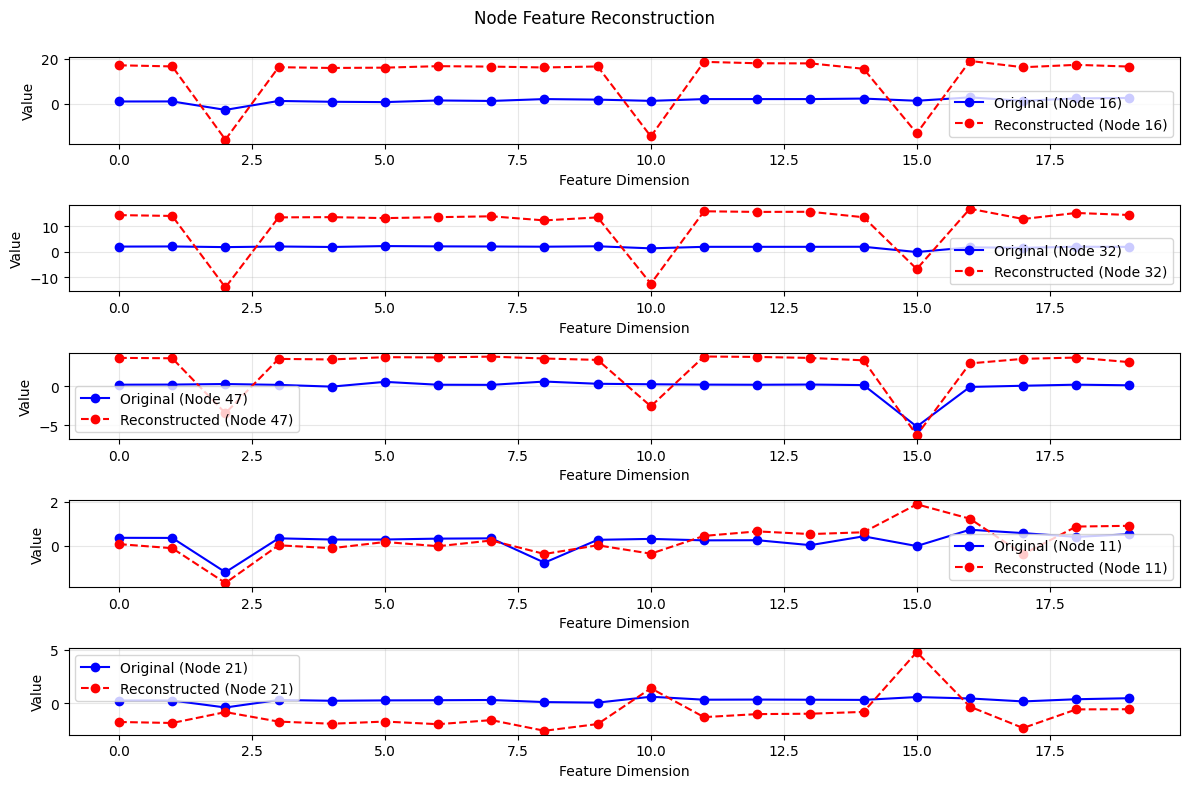

Full grid is not computed, we trigger compute_full_grid_metric_tensor...
Computing metric tensors for 10201 grid points...


Grid compute: 100%|██████████| 10201/10201 [00:00<00:00, 11634.10it/s]


Completed. Cached 10201 / 10201 points.


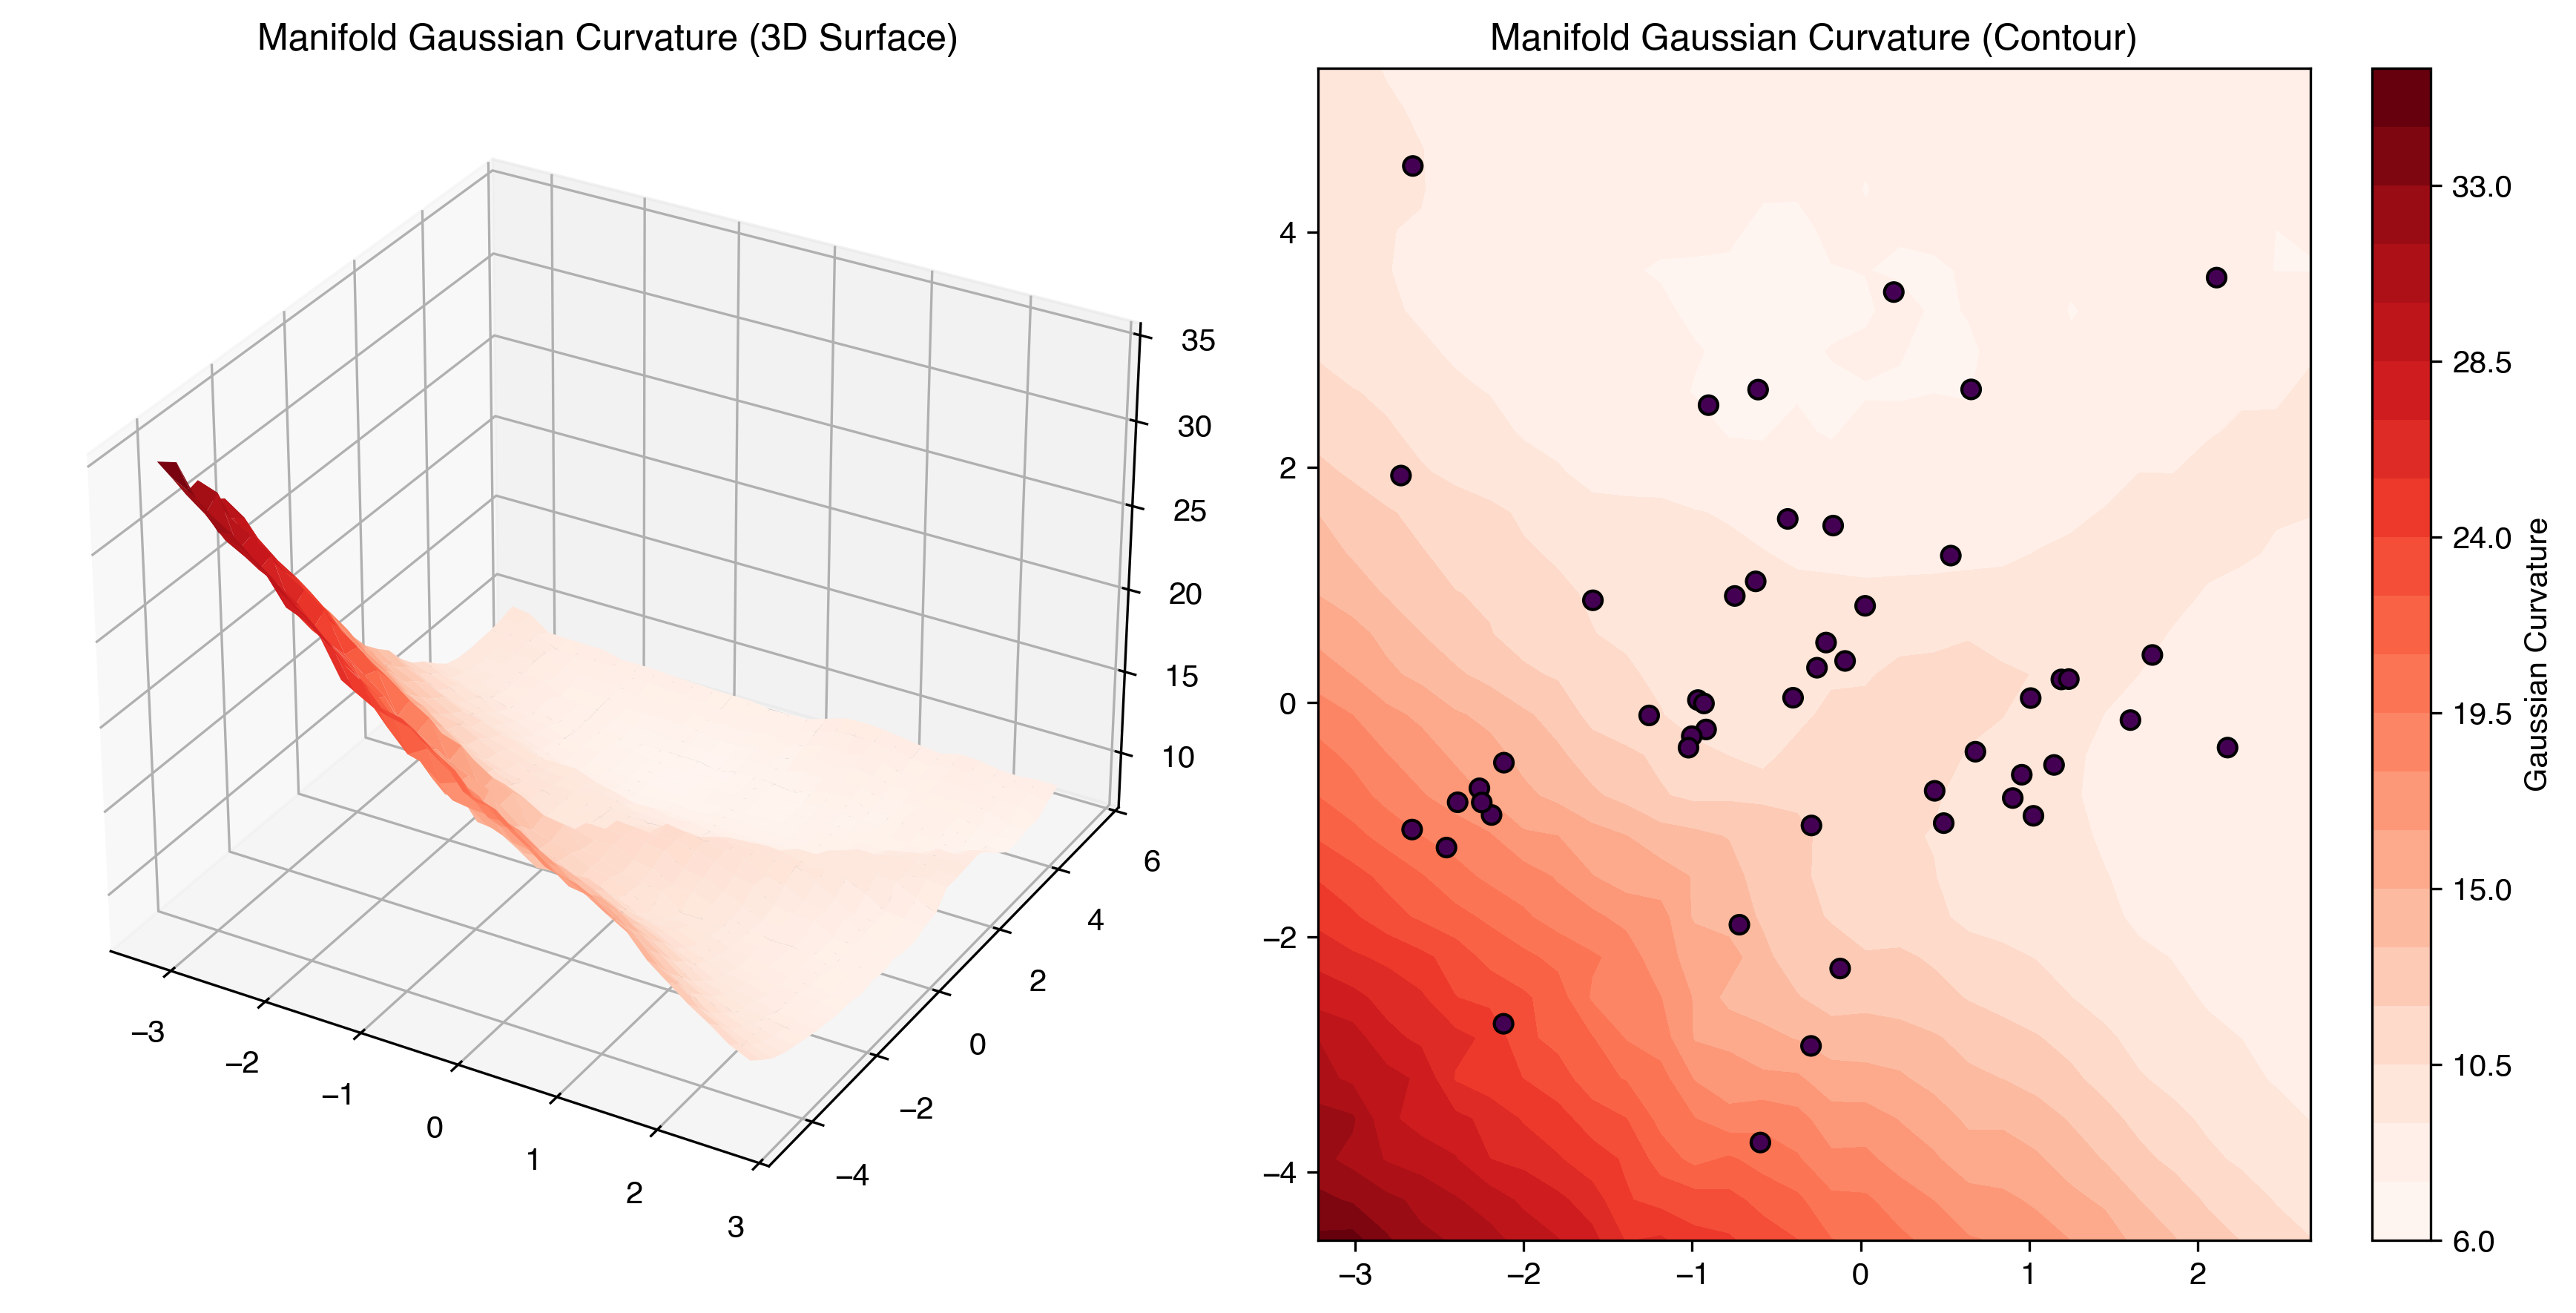

In [19]:
visualize_node_features_reconstruction(model_phase2, single_graph, sample_features=dimP)
with torch.no_grad():
    x = single_graph.x.to(device)
    edge_index = single_graph.edge_index.to(device)
    latent_mu2 = model_phase2.encode(x, edge_index=edge_index)

model_phase2.get_latent_manifold().visualize_manifold_curvature(data_points=latent_mu2[0])

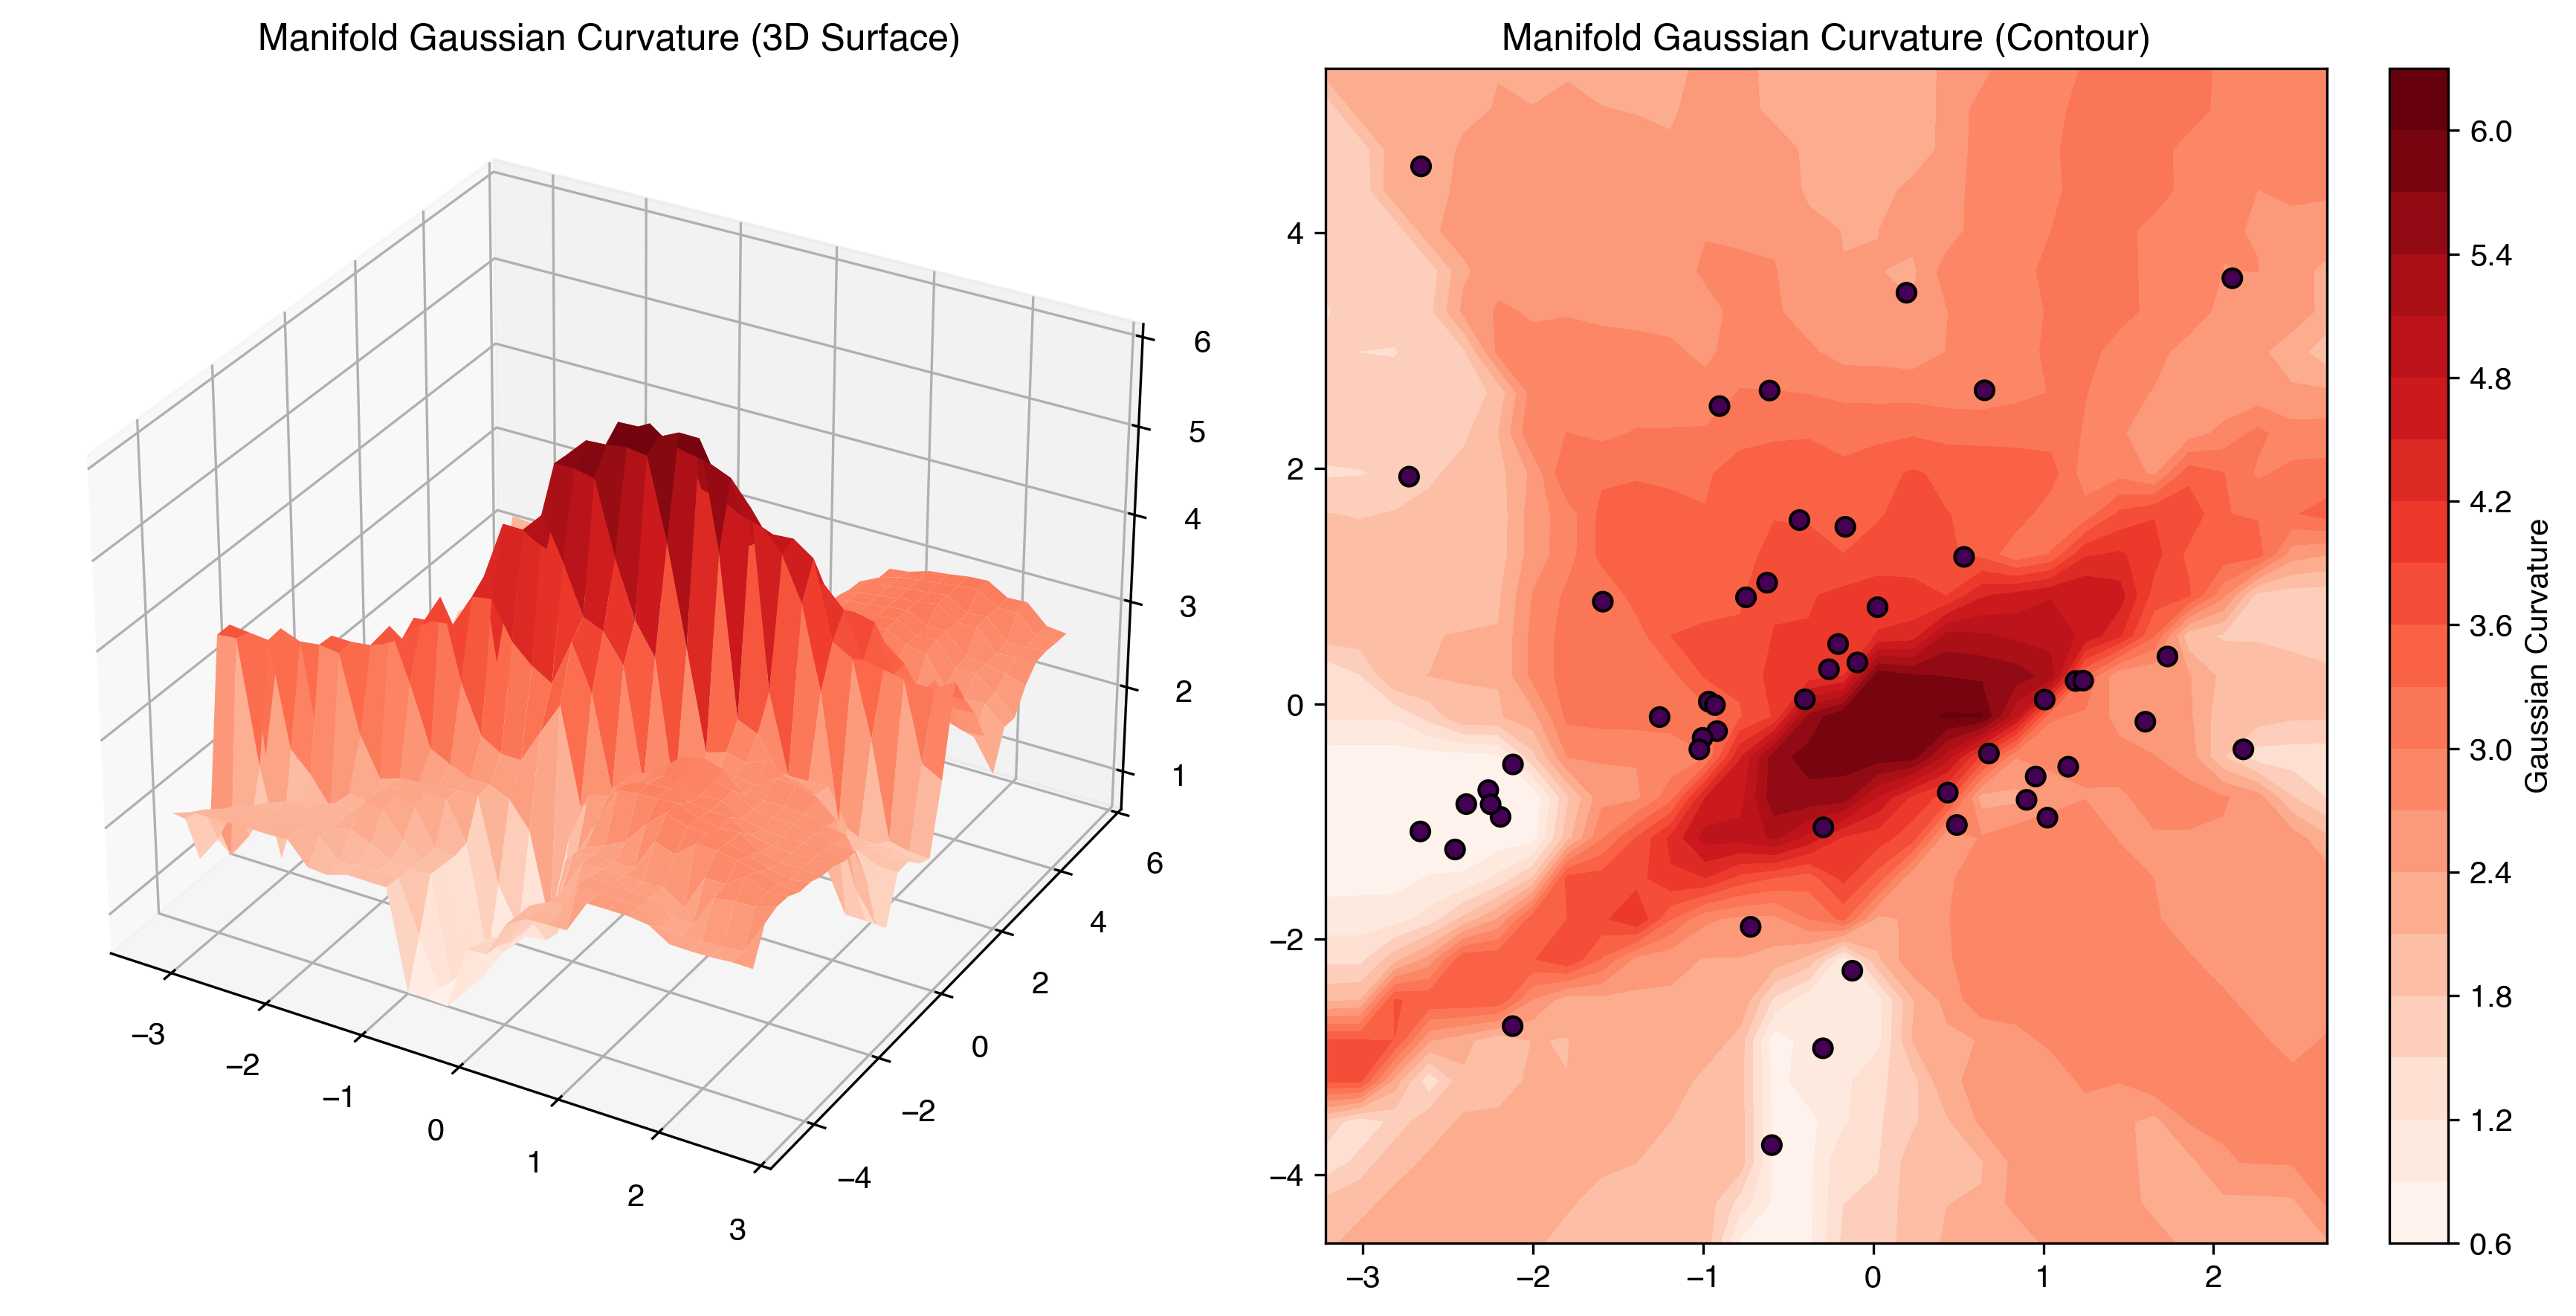

In [20]:
model_phase1.get_latent_manifold().visualize_manifold_curvature(data_points=latent_mu2[0])

In [21]:
history_phase2.keys()

dict_keys(['total_loss', 'kl_loss', 'recon_loss', 'decoder_losses', 'detailed_losses'])

In [22]:
# Combine histories
combined_history = {
    "phase1": history_phase1,
    "phase2": history_phase2
}
visualize_training({"recon_loss": history_phase2["recon_loss"], "kl_loss": [], "decoder_losses": {'ref_loss': history_phase2["detailed_losses"]["adj_decoder"]["ref_loss"], 'dyn_loss': history_phase2["detailed_losses"]["adj_decoder"]["base_loss"]}, "total_loss": history_phase2["total_loss"]})

merged_history = {}
for key in history_phase1.keys():
  if isinstance(history_phase1[key], list):
    merged_history[key] = history_phase1[key] + history_phase2[key]
  else:
     merged_history[key] = dict()
     #for key2 in history_phase1[key].keys():
        #merged_history[key][key2] = history_phase1[key][key2] + history_phase2[key][key2]
      
     for key2 in history_phase2[key].keys():
        if key2 not in history_phase1[key].keys():
          merged_history[key][key2] = [np.nan]*len(history_phase1["kl_loss"]) + history_phase2[key][key2]

visualize_training(merged_history)


NameError: name 'history_phase1' is not defined

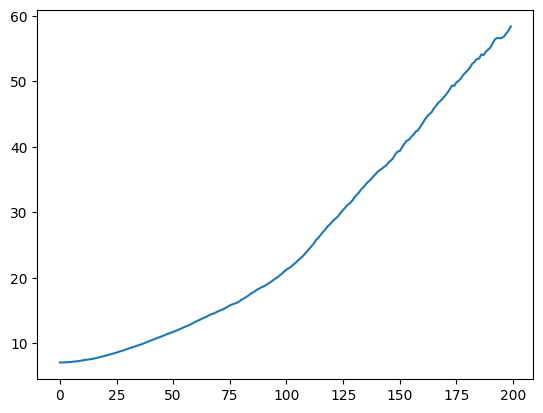

In [23]:
plt.plot(history_phase2["detailed_losses"]["adj_decoder"]["sigma"])

In [24]:
with torch.no_grad():
    if distance_mode == "linear_interpolation":
        dists_phase2 = model_phase2.get_latent_manifold().create_riemannian_distance_matrix(latent_points, 
                                                                                            DistanceApproximations.linear_interpolation_distance, num_points=20)
    elif distance_mode == "dijkstra":
        dists_phase2 = model_phase2.get_latent_manifold().get_grid_as_graph().compute_shortest_paths(
                            latent_points,
                            weight_type="geodesic",  # Uses your metric tensors
                            max_grid_neighbors=8,     # Connect to up to 8 nearest grid nodes
                            num_threads=6
                        )
        

Calculating 1225 pairwise Riemannian distances using linear_interpolation_distance (batch mode)...


Computing distances in batches: 100%|██████████| 154/154 [00:00<00:00, 3097.79it/s]

Distance matrix calculation complete.


In [25]:
resolution = 30
bounds_np = model_phase1.get_latent_manifold().get_bounds().cpu().numpy()
plot_z1 = np.linspace(bounds_np[0, 0], bounds_np[0, 1], resolution)
plot_z2 = np.linspace(bounds_np[1, 0], bounds_np[1, 1], resolution)

Z1_np, Z2_np = np.meshgrid(plot_z1, plot_z2)
Z1, Z2 = torch.from_numpy(Z1_np), torch.from_numpy(Z2_np)
            
curvature_phase1 = torch.zeros((resolution, resolution))
curvature_phase2 = torch.zeros((resolution, resolution))

            
for i in range(resolution):
    for j in range(resolution):
        z = torch.stack([Z1[i, j], Z2[i, j]])
        clamped_z = model_phase1.get_latent_manifold()._clamp_point_to_bounds(z)
        try:
            curv_val_1 = model_phase1.get_latent_manifold().compute_gaussian_curvature(model_phase1.get_latent_manifold().metric_tensor(clamped_z))
            curvature_phase1[i, j] = curv_val_1
        except (ValueError, RuntimeError) as e:
            print(f"Error computing curvature at point {z}: {e}. Setting to NaN.")
            curvature_phase1[i, j] = torch.nan

        try:
            curv_val_2 = model_phase2.get_latent_manifold().compute_gaussian_curvature(model_phase2.get_latent_manifold().metric_tensor(clamped_z))
            curvature_phase2[i, j] = curv_val_2
        except (ValueError, RuntimeError) as e:
            print(f"Error computing curvature at point {z}: {e}. Setting to NaN.")
            curvature_phase2[i, j] = torch.nan
        

/var/folders/qc/fbm2wz190nqd87d2mq7l90_80000gn/T/ipykernel_17939/2181829663.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(points_np[:, 0], points_np[:, 1], cmap='viridis', edgecolors='k')
/var/folders/qc/fbm2wz190nqd87d2mq7l90_80000gn/T/ipykernel_17939/2181829663.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax3.scatter(points_np[:, 0], points_np[:, 1], cmap='viridis', edgecolors='k')


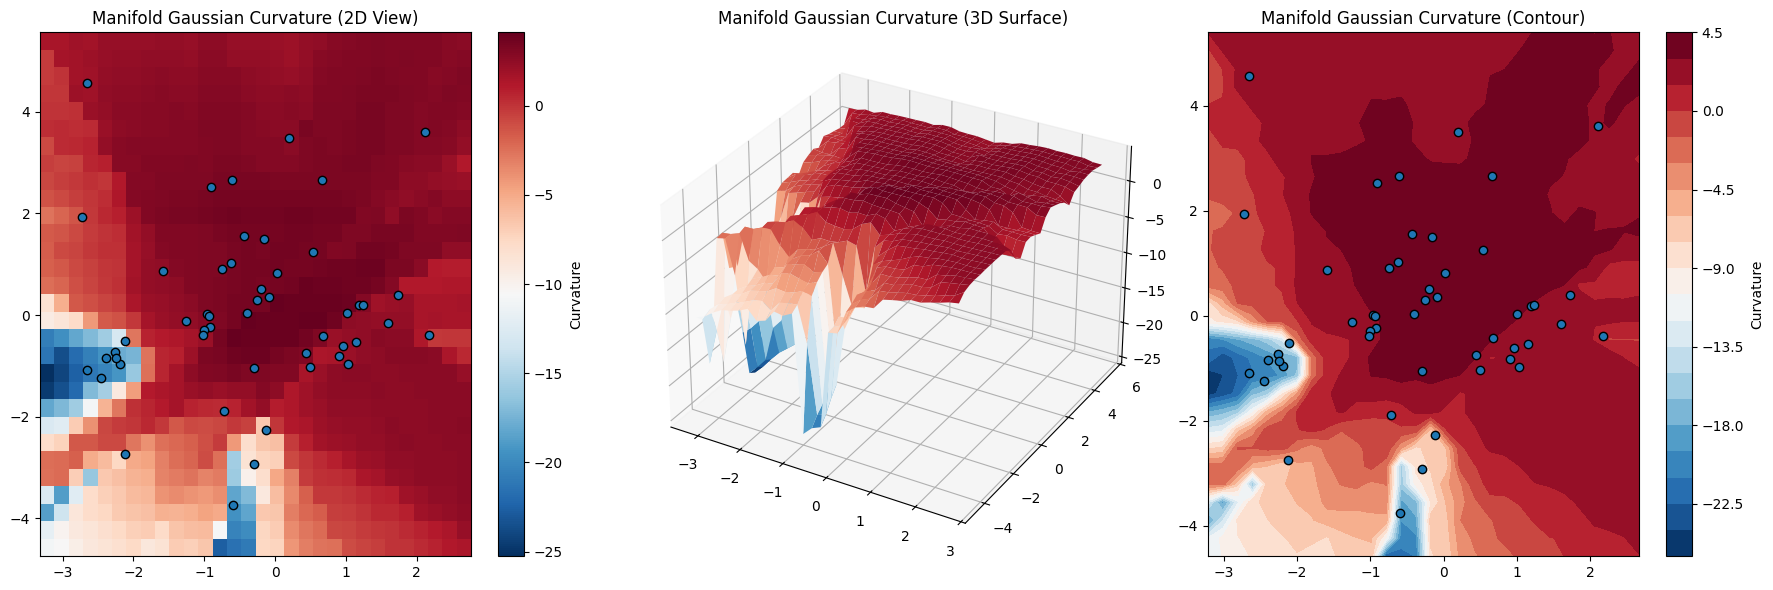

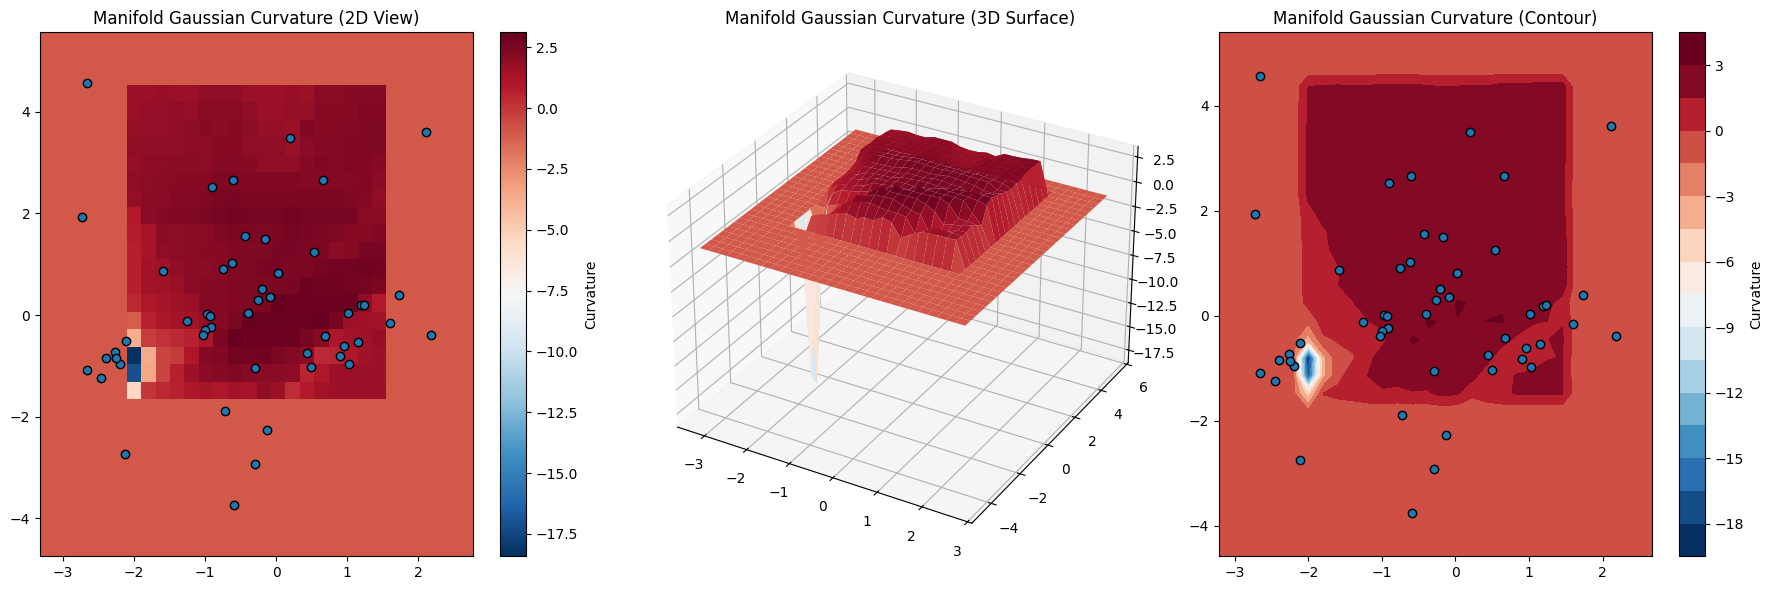

In [26]:
import matplotlib.colors as mpcolors
curvature_diff = (curvature_phase1 - curvature_phase2)/(curvature_phase1 + 1e-8)
curvature_diff = curvature_diff.detach().numpy()

def plot_curv_diff(curvature_diff):
    curvature_diff -= np.mean(curvature_diff)

                
    # --- Plotting Code (using Matplotlib as before) ---
    fig = plt.figure(figsize=(18, 6))
    # ... (The plotting logic is identical, just using the _np versions of arrays)
    vmin, vmax = np.nanmin(curvature_diff), np.nanmax(curvature_diff)
    if np.isnan(vmin) or np.isnan(vmax) or vmin == vmax: vmin, vmax = -1, 1
    norm = mpcolors.Normalize(vmin=vmin, vmax=vmax)
    if vmin < 0 and vmax > 0:
        cmap = 'RdBu_r'
    elif vmin < 0 and vmax <= 0:
        cmap = 'Blues_r'
    else:
        cmap = 'Reds'

    ax1 = fig.add_subplot(131)
    im = ax1.pcolormesh(Z1_np, Z2_np, curvature_diff, cmap=cmap, norm=norm, shading='auto')
    ax1.set_title('Manifold Gaussian Curvature (2D View)')
    plt.colorbar(im, ax=ax1, label='Curvature')

    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(Z1_np, Z2_np, curvature_diff, cmap=cmap, norm=norm)
    ax2.set_title('Manifold Gaussian Curvature (3D Surface)')

    ax3 = fig.add_subplot(133)
    contour = ax3.contourf(Z1_np, Z2_np, curvature_diff, 20, cmap=cmap, norm=norm)
    ax3.set_title('Manifold Gaussian Curvature (Contour)')
    plt.colorbar(contour, ax=ax3, label='Curvature')

    points_np = latent_points.detach().cpu().numpy()
    ax1.scatter(points_np[:, 0], points_np[:, 1], cmap='viridis', edgecolors='k')
    ax3.scatter(points_np[:, 0], points_np[:, 1], cmap='viridis', edgecolors='k')

    plt.tight_layout()
    plt.show()

plot_curv_diff(curvature_diff)

curvature_diff2 = np.zeros_like(curvature_diff)
len1 = curvature_diff.shape[0]
len2 = curvature_diff.shape[1]
curvature_diff2[int(len1*0.3):int(len1*0.9), int(len2*0.2):int(len2*0.8)] = curvature_diff[int(len1*0.3):int(len1*0.9), int(len2*0.2):int(len2*0.8)]
plot_curv_diff(curvature_diff2)


/var/folders/qc/fbm2wz190nqd87d2mq7l90_80000gn/T/ipykernel_17939/904148318.py:10: RuntimeWarning: invalid value encountered in divide
  res3 = ((local_dists_phase1 - dists_phase2)/local_dists_phase1)


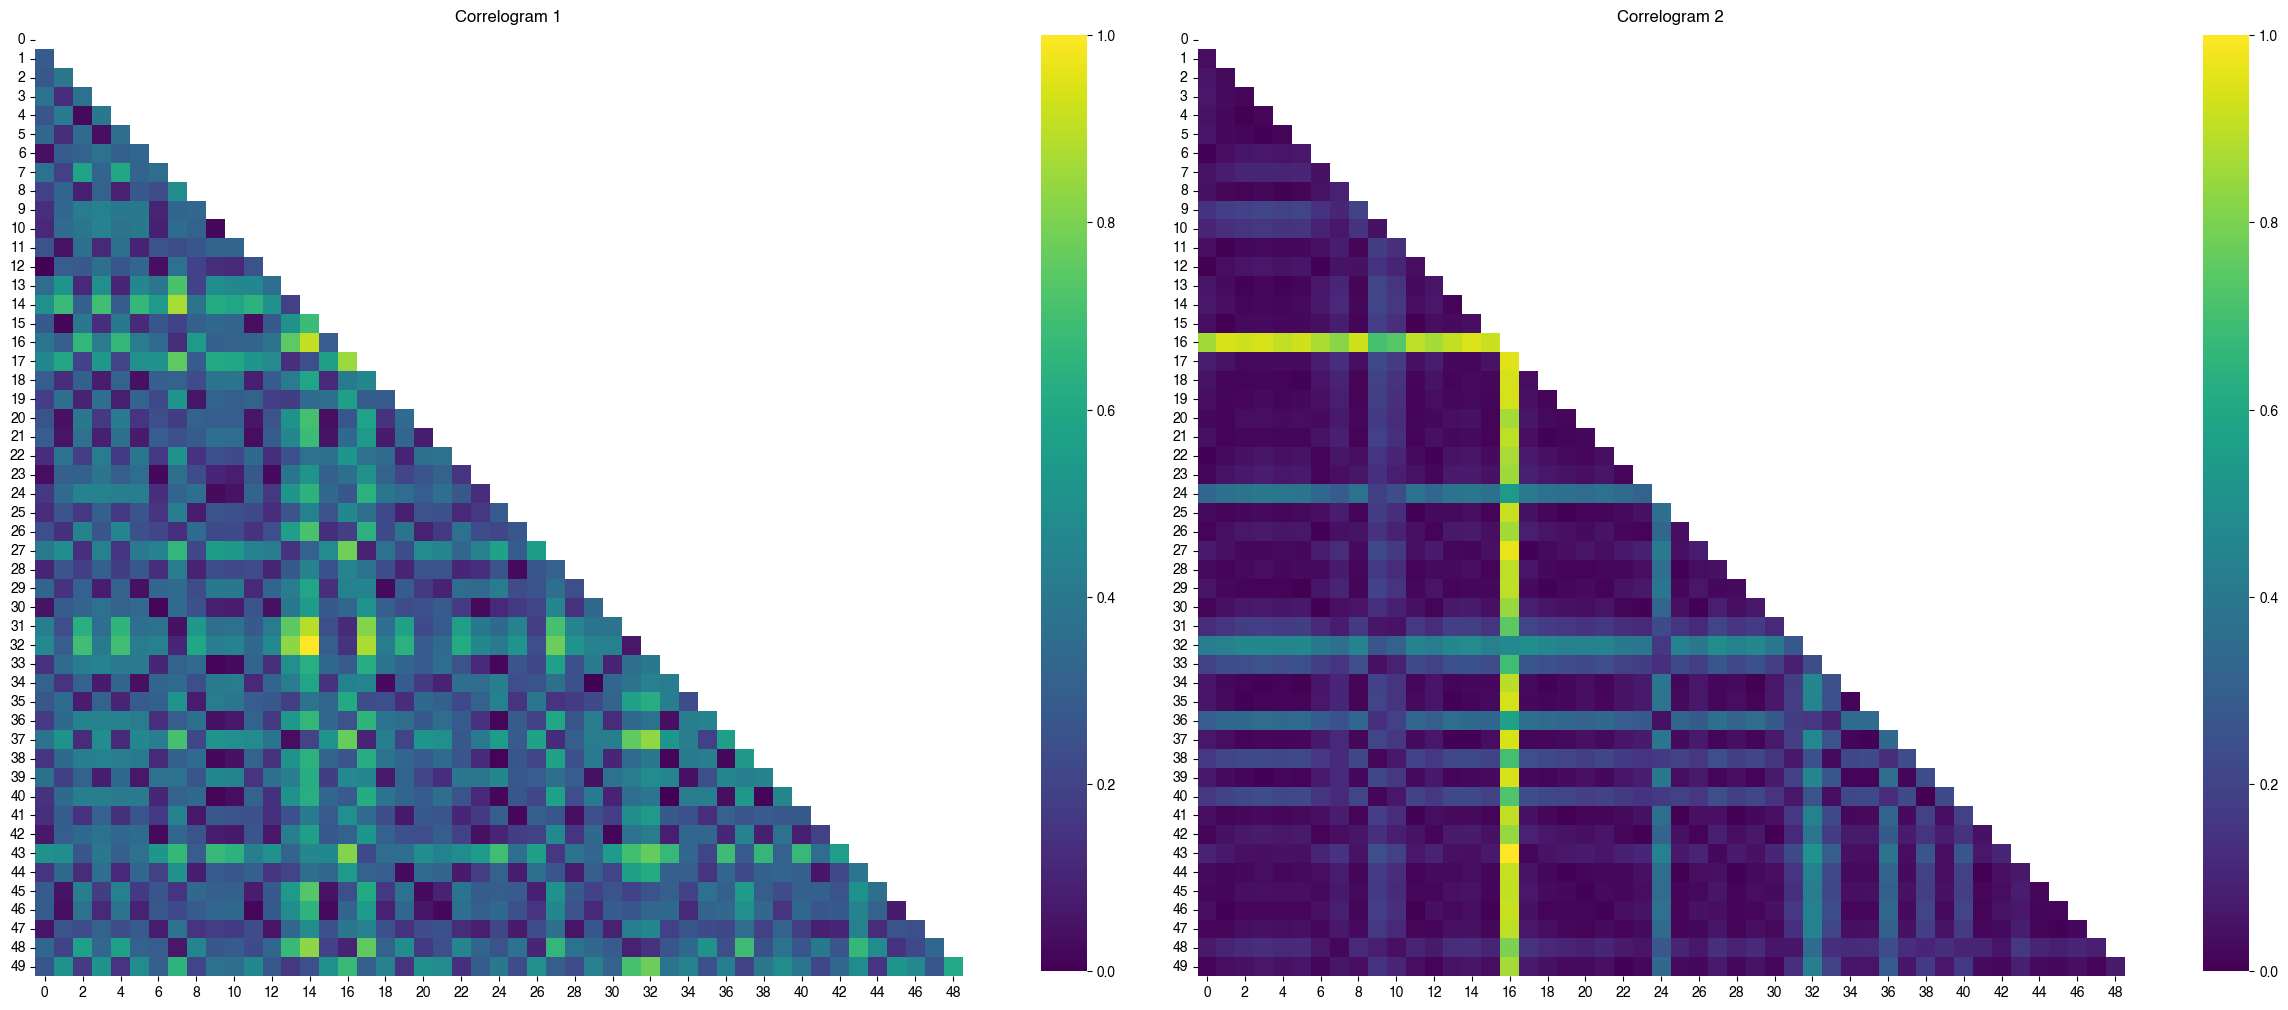

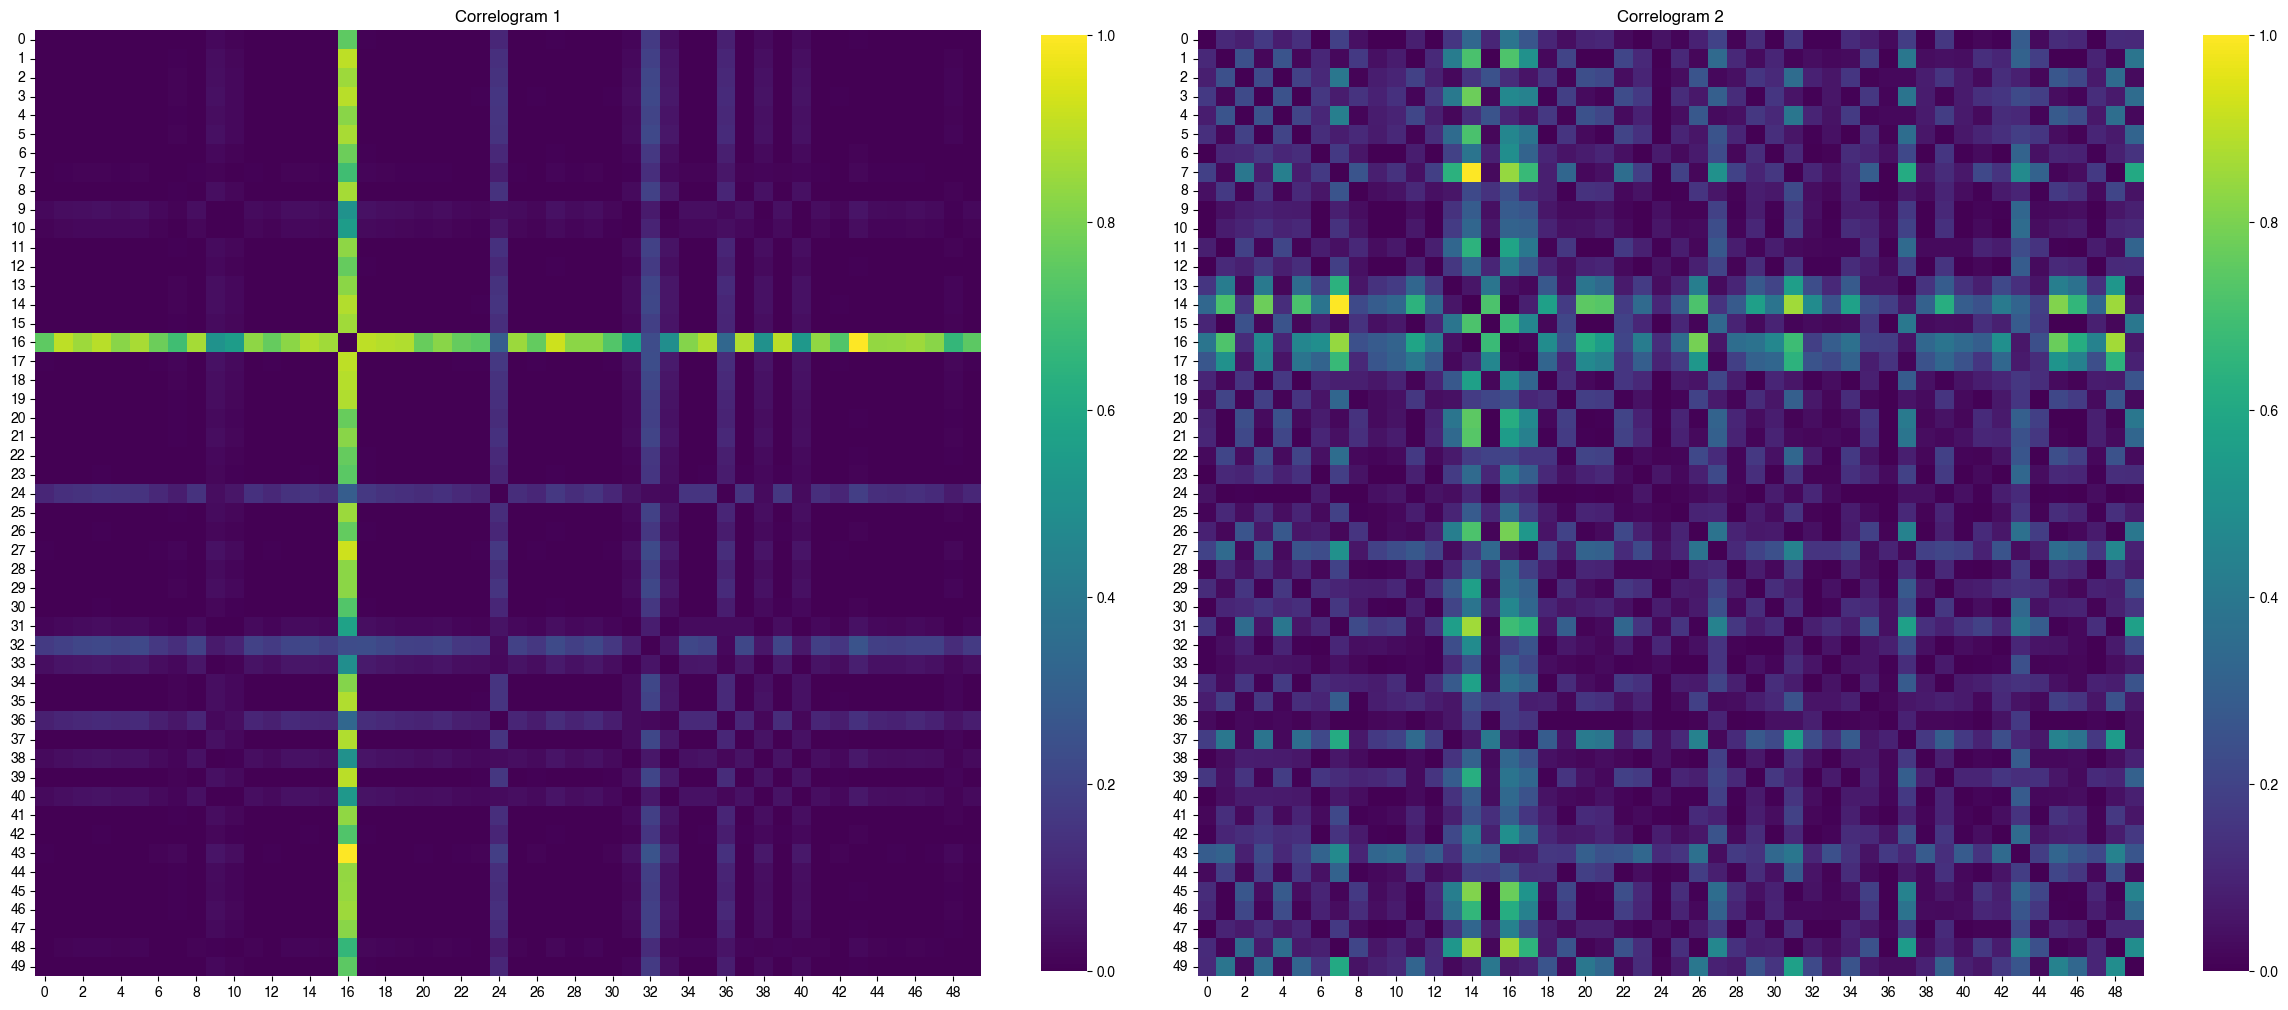

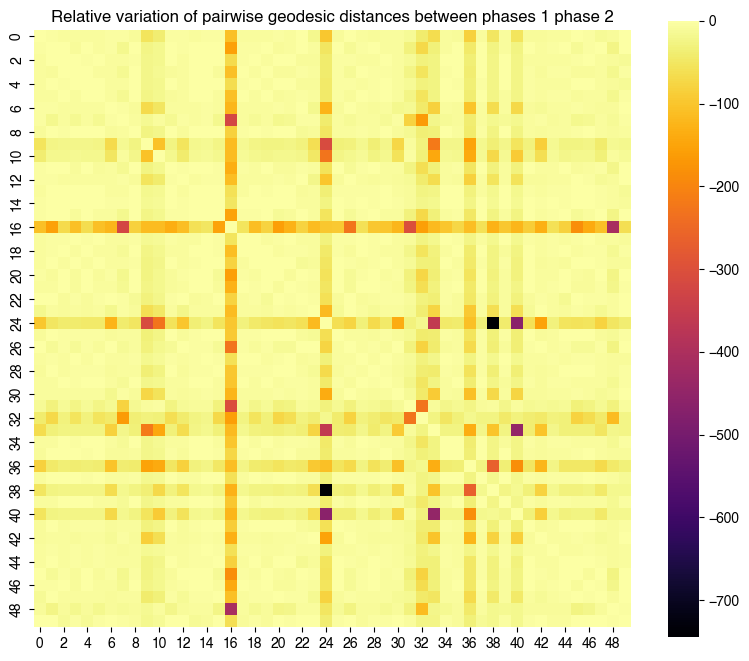

In [ ]:
if isinstance(dists_phase1, torch.Tensor):
    dists_phase1 = dists_phase1.detach().numpy()
if isinstance(dists_phase2, torch.Tensor):
    dists_phase2 = dists_phase2.detach().numpy()

local_dists_phase1 = dists_phase1
if distance_mode == "dijkstra":
    local_dists_phase1 = dists_phase1_dijkstra.detach().numpy()
res = np.abs((local_dists_phase1 - dists_phase2))
res3 = ((local_dists_phase1 - dists_phase2)/local_dists_phase1)
#res3 = np.abs((local_dists_phase1 - dists_phase2)/local_dists_phase1)
res3 = np.nan_to_num(res3, 0)

res3_z = (res3 - np.mean(res3))/np.sqrt(np.var(res3))

res2 = np.abs((local_dists_phase1/np.max(np.where(local_dists_phase1 > 0, local_dists_phase1, 0)) - dists_phase2/np.max(np.where(dists_phase2 > 0, dists_phase2, 0))))

_ = plot_correlogram(local_dists_phase1/np.max(np.where(local_dists_phase1 > 0, local_dists_phase1, 0)), dists_phase2/np.max(np.where(dists_phase2 > 0, dists_phase2, 0)), remove_diagonal=True, triangular=True)

_ = plot_correlogram((res/np.max(res))**2, (res2/np.max(res2))**2)
_ = plot_correlogram(res3, cmap="inferno", titles=["Relative variation of pairwise geodesic distances between phases 1 phase 2"] )

In [ ]:
for i in [0,2, 4, 5, 9, 10, 11, 14, 15, 16, 17, 18, 19]:
    print(cols_to_norm[i])

NameError: name 'cols_to_norm' is not defined

In [ ]:
x.shape[1]

(1266, 13)

In [ ]:
import statsmodels.api as sm

# Knowing that x is:
cols_to_norm = [
    "p20_pop", "p14_pop", "superf", "p20_men", "naisd22", "decesd22",
    "p20_log", "p20_rp", "p20_rsecocc", "p20_logvac", "med20",
    "p20_emplt", "p20_emplt_sal", "p14_emplt", "ettot21", "etaz21",
    "etbe21", "etfz21", "etgu21", "ettefp1021"
]

x = single_graph.x[:, [0,2, 4, 5, 9, 10, 11, 15, 16, 17, 18, 19]].numpy()
x = sm.add_constant(x)
y = res3_z.sum(axis=1).flatten()

model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     39.14
Date:                Thu, 02 Oct 2025   Prob (F-statistic):           3.10e-78
Time:                        21:27:00   Log-Likelihood:                -8955.9
No. Observations:                1266   AIC:                         1.794e+04
Df Residuals:                    1253   BIC:                         1.800e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -49.2990     11.509     -4.283      0.0

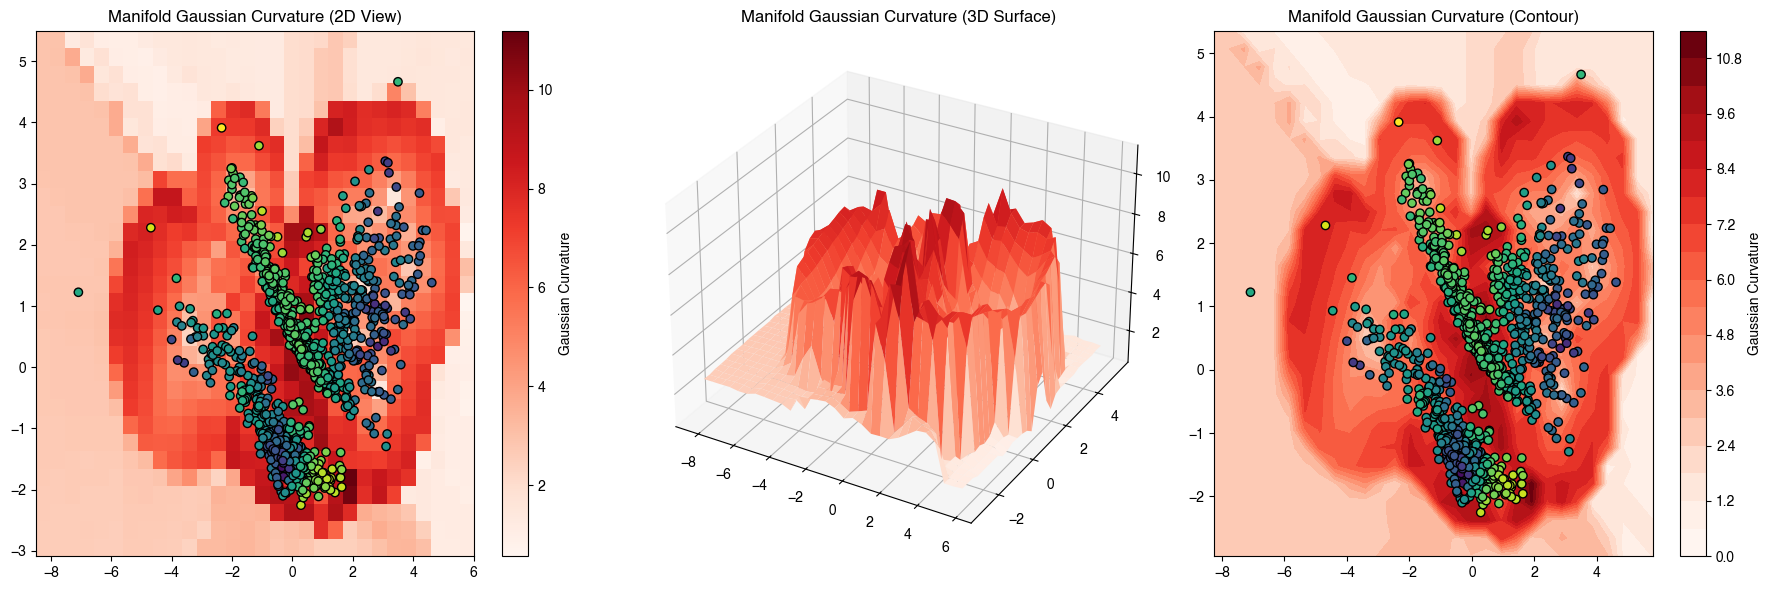

In [ ]:
model_phase1.get_latent_manifold().visualize_manifold_curvature(data_points=latent_points, labels=(torch.tensor(res3.sum(axis=1))))

In [ ]:
import numpy as np

y = res3_z
n = y.shape[0]
pairs = np.triu_indices(n, k=1)  # upper triangle without diagonal
y_pairs = y[pairs]

X_pairs = []
for i, j in zip(*pairs):
    xi, xj = x[i, 1:], x[j, 1:]  # drop constant from original x
    # build symmetric regressors
    feats = np.concatenate([xi + xj, np.abs(xi - xj)])
    X_pairs.append(feats)

X_pairs = np.array(X_pairs)
X_pairs = sm.add_constant(X_pairs)

model = sm.OLS(y_pairs, X_pairs)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     4566.
Date:                Thu, 02 Oct 2025   Prob (F-statistic):               0.00
Time:                        21:27:10   Log-Likelihood:            -1.0851e+06
No. Observations:              800745   AIC:                         2.170e+06
Df Residuals:                  800720   BIC:                         2.171e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3318      0.003   -110.203      0.0

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

y = res3_z
n = y.shape[0]
pairs = np.triu_indices(n, k=1)  # upper triangle
y_pairs = y[pairs]

# original feature names you actually used
cols = [
    "p20_pop", "p14_pop", "superf", "p20_men", "naisd22", "decesd22",
    "p20_log", "p20_rp", "p20_rsecocc", "p20_logvac", "med20",
    "p20_emplt", "p20_emplt_sal", "p14_emplt", "ettot21", "etaz21",
    "etbe21", "etfz21", "etgu21", "ettefp1021"
]

X_pairs = []
for i, j in zip(*pairs):
    xi, xj = x[i, 1:], x[j, 1:]  # drop constant
    feats = np.concatenate([xi + xj, np.abs(xi - xj)])
    X_pairs.append(feats)

X_pairs = np.array(X_pairs)

# Build names dynamically
sum_cols = [f"{c}_sum" for c in cols[:X_pairs.shape[1] // 2]]
diff_cols = [f"{c}_absdiff" for c in cols[:X_pairs.shape[1] // 2]]
regressor_names = ["const"] + sum_cols + diff_cols

# Add constant AFTER naming
X_pairs = sm.add_constant(X_pairs)

# Double-check match
assert X_pairs.shape[1] == len(regressor_names), \
    f"Mismatch: {X_pairs.shape[1]} vs {len(regressor_names)}"

# Fit with clustering
i_idx, j_idx = pairs
clusters = pd.Series(i_idx)  # cluster by first node

model = sm.OLS(y_pairs, X_pairs)
results = model.fit(cov_type="cluster", cov_kwds={"groups": clusters})

print(results.summary(xname=regressor_names))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     227.3
Date:                Thu, 02 Oct 2025   Prob (F-statistic):               0.00
Time:                        21:27:16   Log-Likelihood:            -1.0851e+06
No. Observations:              800745   AIC:                         2.170e+06
Df Residuals:                  800720   BIC:                         2.171e+06
Df Model:                          24                                         
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.3318    

In [ ]:
import pandas as pd

# Pairs
i_idx, j_idx = pairs
clusters = pd.Series(i_idx)  # cluster by first node of the pair

model = sm.OLS(y_pairs, X_pairs)
results = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": clusters}
)

results.summary(xname=regressor_names)

from linearmodels.iv import IV2SLS

df = pd.DataFrame(X_pairs, columns=regressor_names)
df["y"] = y_pairs
df["i"] = i_idx
df["j"] = j_idx

model = IV2SLS.from_formula(
    "y ~ 1 + " + " + ".join(sum_cols + diff_cols),
    data=df
)

# two-way clustering by i and j
res = model.fit(cov_type="clustered", clusters=df[["i", "j"]])
print(res.summary)


                            OLS Estimation Summary                            
Dep. Variable:                      y   R-squared:                      0.1204
Estimator:                        OLS   Adj. R-squared:                 0.1203
No. Observations:              800745   F-statistic:                    2676.7
Date:                Thu, Oct 02 2025   P-value (F-stat)                0.0000
Time:                        21:27:29   Distribution:                 chi2(24)
Cov. Estimator:             clustered                                         
                                                                              
                                  Parameter Estimates                                  
                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------
Intercept              -0.3318     0.0341    -9.7204     0.0000     -0.3987     -0.2649
p20_pop_sum     

In [ ]:
import pandas as pd

def classify_pairwise_regression(results, regressor_names, alpha=0.05):
    """
    Classify pairwise regression coefficients into categories:
    - Convergence drivers
    - Divergence drivers
    - Homophily
    - Heterophily
    Only coefficients with p < alpha are considered significant.
    """

    coef = results.params
    df = pd.DataFrame({
        "regressor": regressor_names,
        "coef": coef,
        "pval": results.pvalues
    })

    # keep only significant variables
    df_sig = df[df["pval"] < alpha]

    categories = {"convergence": [], "divergence": [], "homophily": [], "heterophily": []}

    for _, row in df_sig.iterrows():
        name, c = row["regressor"], row["coef"]

        if name.endswith("_sum"):
            if c > 0:
                categories["convergence"].append((name, c))
            elif c < 0:
                categories["divergence"].append((name, c))

        elif name.endswith("_absdiff"):
            if c > 0:
                categories["heterophily"].append((name, c))
            elif c < 0:
                categories["homophily"].append((name, c))

    # Print with explanations
    print("\nInterpretation of regression results (significant at p < {}):".format(alpha))
    print("• Convergence: positive _sum → larger joint values reduce relative distance.")
    print("• Divergence: negative _sum → larger joint values increase relative distance.")
    print("• Homophily: negative _absdiff → similarity reduces distance.")
    print("• Heterophily: positive _absdiff → dissimilarity reduces distance.\n")

    for cat, vars_ in categories.items():
        if vars_:
            print(f"{cat.capitalize()} drivers:")
            for name, coef in vars_:
                print(f"  - {name}: {coef:.4f}")
            print("")

    return categories, df, df_sig

classify_pairwise_regression(results, regressor_names)


Interpretation of regression results (significant at p < 0.05):
• Convergence: positive _sum → larger joint values reduce relative distance.
• Divergence: negative _sum → larger joint values increase relative distance.
• Homophily: negative _absdiff → similarity reduces distance.
• Heterophily: positive _absdiff → dissimilarity reduces distance.

Convergence drivers:
  - p14_pop_sum: 0.0203
  - decesd22_sum: 0.0110
  - p20_rsecocc_sum: 0.0261
  - p20_logvac_sum: 0.0205
  - p20_emplt_sum: 0.0768

Divergence drivers:
  - naisd22_sum: -0.0354
  - p20_log_sum: -0.0764
  - p20_rp_sum: -0.0458

Homophily drivers:
  - superf_absdiff: -0.0744
  - p20_men_absdiff: -0.0628
  - p20_rp_absdiff: -0.0169
  - p20_logvac_absdiff: -0.0226
  - med20_absdiff: -0.0406

Heterophily drivers:
  - p20_pop_absdiff: 0.3334
  - p20_rsecocc_absdiff: 0.0591
  - p20_emplt_absdiff: 0.0643



({'convergence': [('p14_pop_sum', 0.02030996051910961),
   ('decesd22_sum', 0.011003305115550392),
   ('p20_rsecocc_sum', 0.026143341571153337),
   ('p20_logvac_sum', 0.0205268253152861),
   ('p20_emplt_sum', 0.07675159972855268)],
  'divergence': [('naisd22_sum', -0.03537305789597541),
   ('p20_log_sum', -0.07644807456642047),
   ('p20_rp_sum', -0.04575281037960821)],
  'homophily': [('superf_absdiff', -0.07443572714301952),
   ('p20_men_absdiff', -0.06280661192026615),
   ('p20_rp_absdiff', -0.016886758244594603),
   ('p20_logvac_absdiff', -0.02256235795318368),
   ('med20_absdiff', -0.040586138828265235)],
  'heterophily': [('p20_pop_absdiff', 0.3333739585021454),
   ('p20_rsecocc_absdiff', 0.059071960238514055),
   ('p20_emplt_absdiff', 0.06434504888014571)]},
               regressor      coef           pval
 0                 const -0.331758   9.525422e-43
 1           p20_pop_sum -0.013241   6.553347e-01
 2           p14_pop_sum  0.020310   3.569925e-04
 3            superf_sum 

In [ ]:
torch.save(model_phase1.state_dict(), 'model_phase1_geo.pth')
torch.save(model_phase1.state_dict(), 'model_phase2_geo.pth')


### Original distances

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm


y = adjacency_matrix
x = p_vectors_array[:, [0,2, 4, 5, 9, 10, 11, 15, 16, 17, 18, 19]]
x = sm.add_constant(x)
n = y.shape[0]
pairs = np.triu_indices(n, k=1)  # upper triangle
y_pairs = y[pairs]

# original feature names you actually used
cols = [
    "p20_pop", "p14_pop", "superf", "p20_men", "naisd22", "decesd22",
    "p20_log", "p20_rp", "p20_rsecocc", "p20_logvac", "med20",
    "p20_emplt", "p20_emplt_sal", "p14_emplt", "ettot21", "etaz21",
    "etbe21", "etfz21", "etgu21", "ettefp1021"
]

X_pairs = []
for i, j in zip(*pairs):
    xi, xj = x[i, 1:], x[j, 1:]  # drop constant
    feats = np.concatenate([xi + xj, np.abs(xi - xj)])
    X_pairs.append(feats)

X_pairs = np.array(X_pairs)

# Build names dynamically
sum_cols = [f"{c}_sum" for c in cols[:X_pairs.shape[1] // 2]]
diff_cols = [f"{c}_absdiff" for c in cols[:X_pairs.shape[1] // 2]]
regressor_names = ["const"] + sum_cols + diff_cols

# Add constant AFTER naming
X_pairs = sm.add_constant(X_pairs)

# Double-check match
assert X_pairs.shape[1] == len(regressor_names), \
    f"Mismatch: {X_pairs.shape[1]} vs {len(regressor_names)}"

# Fit with clustering
i_idx, j_idx = pairs
clusters = pd.Series(i_idx)  # cluster by first node

model = sm.OLS(y_pairs, X_pairs)
results = model.fit(cov_type="cluster", cov_kwds={"groups": clusters})

print(results.summary(xname=regressor_names))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.412
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           1.39e-15
Time:                        17:57:05   Log-Likelihood:             2.8533e+06
No. Observations:              800745   AIC:                        -5.707e+06
Df Residuals:                  800720   BIC:                        -5.706e+06
Df Model:                          24                                         
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0004   5

In [ ]:
import pandas as pd

# Pairs
i_idx, j_idx = pairs
clusters = pd.Series(i_idx)  # cluster by first node of the pair

model = sm.OLS(y_pairs, X_pairs)
results = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": clusters}
)

results.summary(xname=regressor_names)

from linearmodels.iv import IV2SLS

df = pd.DataFrame(X_pairs, columns=regressor_names)
df["y"] = y_pairs
df["i"] = i_idx
df["j"] = j_idx

model = IV2SLS.from_formula(
    "y ~ 1 + " + " + ".join(sum_cols + diff_cols),
    data=df
)

# two-way clustering by i and j
res = model.fit(cov_type="clustered", clusters=df[["i", "j"]])
print(res.summary)

                            OLS Estimation Summary                            
Dep. Variable:                      y   R-squared:                      0.0031
Estimator:                        OLS   Adj. R-squared:                 0.0031
No. Observations:              800745   F-statistic:                    115.83
Date:                Thu, Sep 25 2025   P-value (F-stat)                0.0000
Time:                        17:58:24   Distribution:                 chi2(24)
Cov. Estimator:             clustered                                         
                                                                              
                                  Parameter Estimates                                  
                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------
Intercept               0.0004  7.647e-05     4.8853     0.0000      0.0002      0.0005
p20_pop_sum     

In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

class PlotlyNodeViewer:
    def __init__(self, single_graph, model_phase1, latent_points, names):
        self.single_graph = single_graph
        self.model_phase1 = model_phase1
        self.latent_points = latent_points
        self.names = names
        self.num_nodes = len(names)
        
        # Create subplot figure
        self.fig = make_subplots(
            rows=1, cols=2,
            subplot_titles=('Node Reconstruction', 'Points on Manifold - Click to Select'),
            horizontal_spacing=0.1
        )
        
        # Initial selected index
        self.selected_idx = 0
        
        # Add manifold scatter plot
        points_np = self.latent_points.detach().cpu().numpy()
        
        self.fig.add_trace(
            go.Scatter(
                x=points_np[:, 0],
                y=points_np[:, 1],
                mode='markers',
                marker=dict(size=8, color='lightblue', line=dict(width=1, color='black')),
                text=[f"{i}: {name}" for i, name in enumerate(self.names)],
                hovertemplate='<b>%{text}</b><br>X: %{x:.3f}<br>Y: %{y:.3f}<extra></extra>',
                name='Nodes'
            ),
            row=1, col=2
        )
        
        # Highlight selected point
        self.fig.add_trace(
            go.Scatter(
                x=[points_np[0, 0]],
                y=[points_np[0, 1]],
                mode='markers',
                marker=dict(size=12, color='red', line=dict(width=2, color='darkred')),
                name='Selected',
                showlegend=False
            ),
            row=1, col=2
        )
        
        # Add initial reconstruction
        self.update_reconstruction(0)
        
        # Set up click callback
        self.fig.data[0].on_click(self.on_click)
        
        # Update layout
        self.fig.update_layout(
            title='Interactive Node Reconstruction Viewer',
            height=500,
            showlegend=True
        )
        
        self.fig.show()
    
    def on_click(self, trace, points, selector):
        """Handle click events on scatter plot"""
        if points.point_inds:
            self.selected_idx = points.point_inds[0]
            
            # Update highlight position
            points_np = self.latent_points.detach().cpu().numpy()
            self.fig.data[1].x = [points_np[self.selected_idx, 0]]
            self.fig.data[1].y = [points_np[self.selected_idx, 1]]
            
            # Update reconstruction
            self.update_reconstruction(self.selected_idx)
    
    def update_reconstruction(self, idx):
        """Update reconstruction plot"""
        # Get original and reconstructed data
        a = self.single_graph.x[idx]
        a_r = self.model_phase1(self.single_graph.x[idx].unsqueeze(0))
        
        original = a.detach().cpu().numpy()
        reconstructed = a_r["outputs"]["node_attr_decoder"]["node_features"].detach().squeeze().cpu().numpy()
        
        # Remove existing reconstruction traces if any
        traces_to_remove = []
        for i, trace in enumerate(self.fig.data):
            if trace.name in ['Original', 'Reconstructed']:
                traces_to_remove.append(i)
        
        for i in reversed(traces_to_remove):
            self.fig.data = self.fig.data[:i] + self.fig.data[i+1:]
        
        # Add new reconstruction traces
        x_vals = list(range(len(original)))
        
        self.fig.add_trace(
            go.Scatter(
                x=x_vals,
                y=original,
                mode='lines+markers',
                name='Original',
                line=dict(color='blue', width=2),
                marker=dict(size=6)
            ),
            row=1, col=1
        )
        
        self.fig.add_trace(
            go.Scatter(
                x=x_vals,
                y=reconstructed,
                mode='lines+markers',
                name='Reconstructed',
                line=dict(color='orange', width=2, dash='dash'),
                marker=dict(size=6, symbol='square')
            ),
            row=1, col=1
        )
        
        # Update subplot title
        self.fig.layout.annotations[0].text = f'Reconstruction: {idx} - {self.names[idx]}'


# Even simpler version using Plotly widgets
def create_simple_plotly_viewer(single_graph, model_phase1, latent_points, names):
    """Simple function-based approach"""
    import ipywidgets as widgets
    from IPython.display import display
    
    def plot_reconstruction(idx):
        # Get data
        a = single_graph.x[idx]
        a_r = model_phase1(single_graph.x[idx].unsqueeze(0))
        
        original = a.detach().cpu().numpy()
        reconstructed = a_r["outputs"]["node_attr_decoder"]["node_features"].detach().squeeze().cpu().numpy()
        points_np = latent_points.detach().cpu().numpy()
        
        # Create subplots
        fig = make_subplots(
            rows=1, cols=2,
            subplot_titles=(f'Reconstruction: {idx} - {names[idx]}', 'Points on Manifold')
        )
        
        # Reconstruction plot
        x_vals = list(range(len(original)))
        fig.add_trace(
            go.Scatter(x=x_vals, y=original, mode='lines+markers', 
                      name='Original', line=dict(color='blue')),
            row=1, col=1
        )
        fig.add_trace(
            go.Scatter(x=x_vals, y=reconstructed, mode='lines+markers',
                      name='Reconstructed', line=dict(color='orange', dash='dash')),
            row=1, col=1
        )
        
        # Manifold plot with highlight
        colors = ['red' if i == idx else 'lightblue' for i in range(len(points_np))]
        sizes = [12 if i == idx else 8 for i in range(len(points_np))]
        
        fig.add_trace(
            go.Scatter(
                x=points_np[:, 0], y=points_np[:, 1],
                mode='markers',
                marker=dict(size=sizes, color=colors, line=dict(width=1, color='black')),
                text=[f"{i}: {name}" for i, name in enumerate(names)],
                hovertemplate='<b>%{text}</b><br>X: %{x:.3f}<br>Y: %{y:.3f}<extra></extra>',
                showlegend=False
            ),
            row=1, col=2
        )
        
        fig.update_layout(height=500, title='Node Reconstruction Viewer')
        fig.show()
    
    # Create slider widget
    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(names)-1,
        step=1,
        description='Node:',
        continuous_update=False
    )
    
    # Create interactive widget
    interactive_plot = widgets.interactive(plot_reconstruction, idx=slider)
    display(interactive_plot)
    
    return interactive_plot

# Usage:
# Method 1 - Click-based (more advanced):
#viewer = PlotlyNodeViewer(single_graph, model_phase1, latent_points, names)

# Method 2 - Slider-based (simpler, guaranteed to work):
interactive_plot = create_simple_plotly_viewer(single_graph, model_phase1, latent_points, names)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Node:', max=1265), Output()), _…